# Proyecto final - IA "Titánica"
### Programación de Inteligencia Artificial
### Juan Antonio Donet
[Github](https://github.com/hechix/IA_Titanica)

# Contexto

El proyecto consiste en crear la mejor IA posible, que sea capaz de predecir si los tripulantes del Titanic sobreviven, o si se van a grabar la película "La Sirenita" en versión personas.

# Estrategia

Yo visualizo todas las posibles permutaciones de esta IA como un cubo multidimensional de N lados, por ejemplo:

- Cantidad de capas
- Activación de capas internas
- Activación de capa de salida
- Algoritmo de optimización
- Tasa de aprendizaje
- Métricas para calcular su precisión
- Etcétera

Como iterar a través de todas y cada una de las iteraciones del cubo es muy ineficiente, voy a crear una serie de modelos "originales", e ir mutandolos de forma generacional, para buscar la mejor versión de cada modelo y descartar los ineficientes.

En concreto, voy a explorar:

- 3 Tipos de normalizacion
    - Sin normalizar
    - Normalizado 0 a 1
    - Onehot
- 8 Semillas
    - 1 
    - 3
    - 5
    - 7
    - 11
    - 123
    - 666
    - 1024
- 8 Arquitecturas de red
    - 1 capa
    - 3 capas
    - 5 capas
    - 7 capas
    - 11 capas
    - 13 capas
    - 15 capas
- 3 Funciones de coste
    - Binnary crossentropy
    - Mean squared error
    - Mean absolute error
- 8 Optimizadores
    - SGD
    - RMSprop
    - Adam
    - Adadelta
    - Adagrad
    - Adamax
    - Nadam
    - FTRL
- 7 Activaciones de capa externa
    - Sigmoide
    - ReLU
    - Swish
    - Linear
    - Softmax
    - SELU
    - Tanh
- 7 Activaciones de capa interna
    - Sigmoide
    - ReLU
    - Swish
    - Linear
    - Softmax
    - SELU
    - Tanh

En cada fase del proyecto purgaré todos los modelos que no estén en el top 3 de mejor rendimiento para mutar los del top 3 en la siguiente fase.

# 0. Importes, carga y preparación de datos

## 0.1 Cargar y limpiar.

In [163]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.ticker as plticker
from tabulate import tabulate
import math
import matplotlib.colors as colors
from keras import backend as K
import os
import json

warnings.filterwarnings("ignore")

In [164]:
# https://www.kaggle.com/datasets/heptapod/titanic
datos = pd.read_csv('titanic.csv')
datos.shape

(1309, 28)

### 0.2 Quitar las columnas a 0.

In [165]:
datos = datos[['Age', 'Fare', 'Sex', 'sibsp', 'Parch', 'Pclass', 'Embarked', 'Survived']]
datos.shape

(1309, 8)

## 0.2 Exploración de los datos.

### 0.2.1 Visualizar pirámides generacionales por supervivencia.

In [166]:
piramide = datos[['Age','Sex','Survived']]
piramide.Age = piramide.Age.apply(lambda x : int(x / 5) * 5)
piramide.Sex = piramide.Sex.apply(lambda x : 'M' if x else 'H')
piramide = piramide.groupby(['Age','Sex','Survived']).size().reset_index()
piramide = piramide.rename({0:'Total'}, axis='columns')

piramide.head()

,Age,Sex,Survived,Total
0,0,H,0,12
1,0,H,1,15
2,0,M,0,12
3,0,M,1,12
4,5,H,0,12


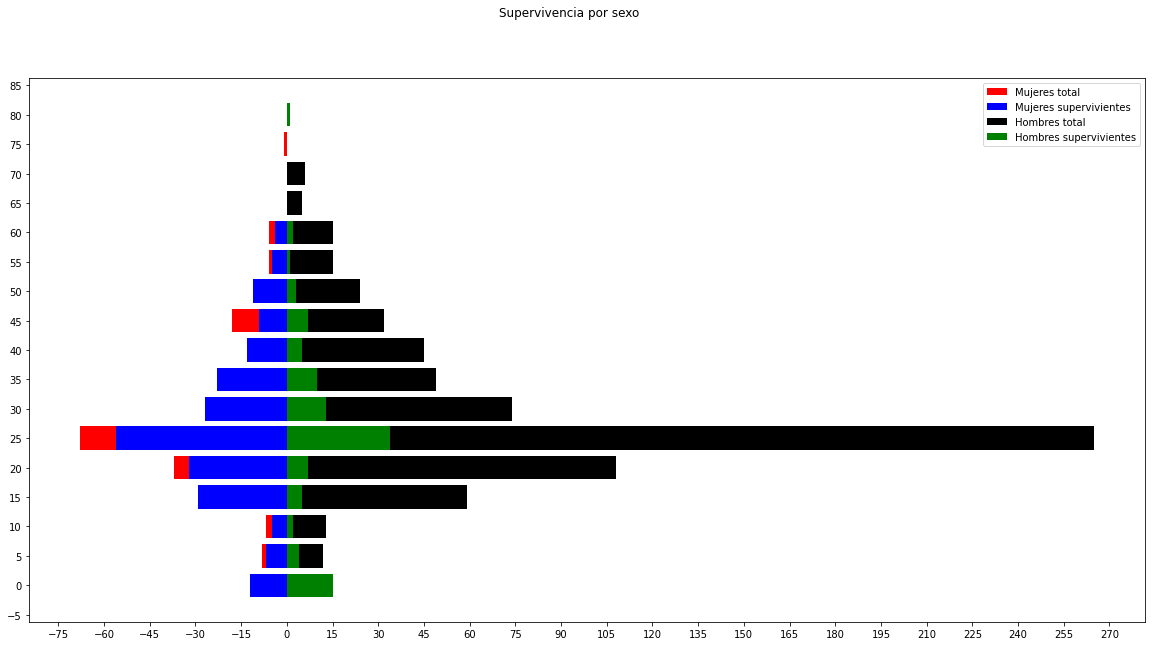

In [167]:
figura = plt.figure(figsize=(20,10))
figura.suptitle('Supervivencia por sexo')

hueco = figura.add_subplot(1,1,1)

hombr_superviv = piramide.mask((piramide.Sex == 'M') | (piramide.Survived == 0)).dropna()
hombr_total = piramide.mask((piramide.Sex == 'M') ).dropna()

mujer_superviv = piramide.mask((piramide.Sex == 'H') | (piramide.Survived == 0)).dropna()
mujer_total = piramide.mask((piramide.Sex == 'H') ).dropna()

hueco.barh(mujer_total.Age, -mujer_total.Total, color = 'red', label ='Mujeres total', height=4)
hueco.barh(mujer_superviv.Age, -mujer_superviv.Total, color = 'blue', label = 'Mujeres supervivientes', height=4)

hueco.barh(hombr_total.Age,hombr_total.Total, color = 'black', label = 'Hombres total', height=4)
hueco.barh(hombr_superviv.Age,hombr_superviv.Total, color = 'green', label = 'Hombres supervivientes', height=4)

hueco.legend()


y_loc = plticker.MultipleLocator(base=5.0)
x_loc = plticker.MultipleLocator(base=15.0)
hueco.yaxis.set_major_locator(y_loc)
hueco.xaxis.set_major_locator(x_loc)

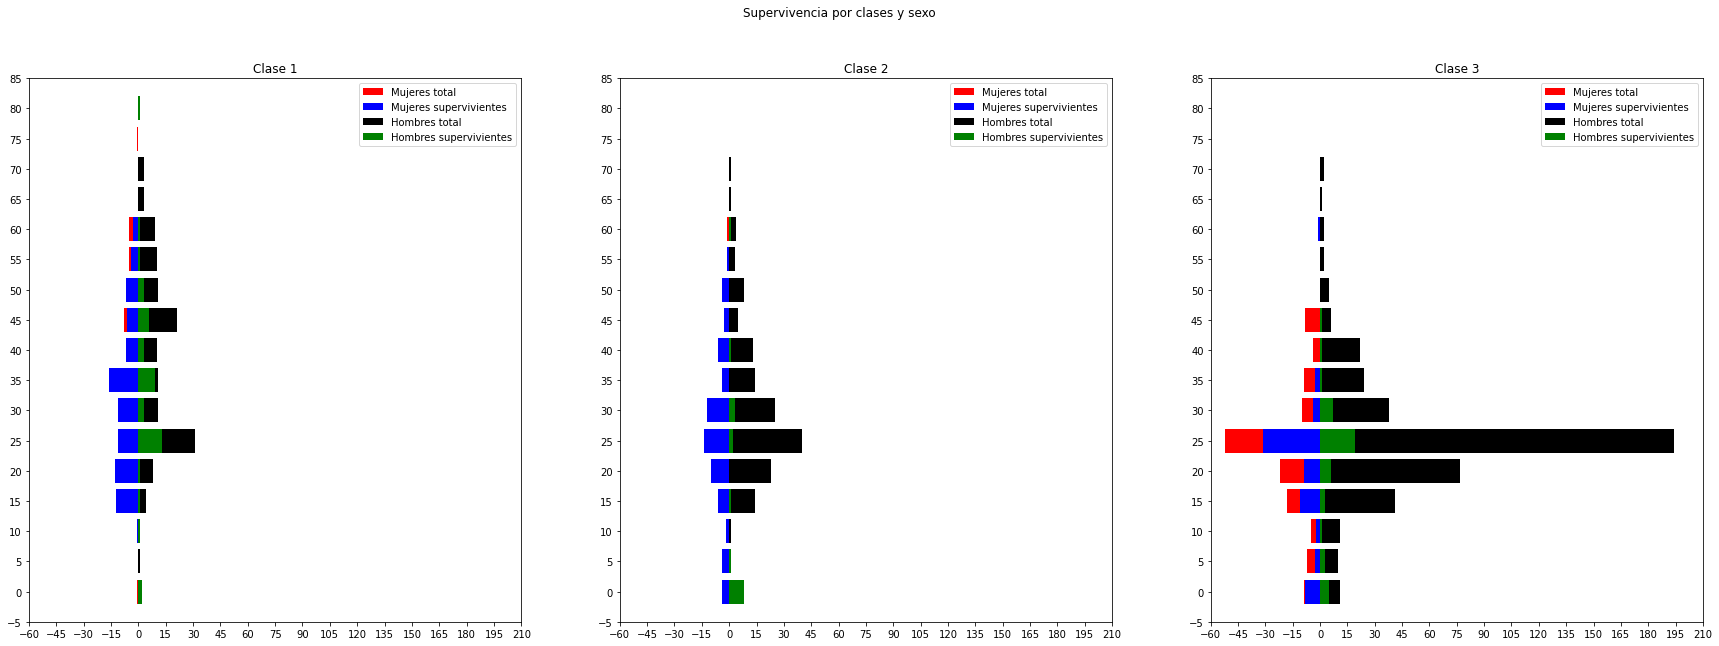

In [168]:
def calcula_piramide(datos, clase, figura):
    piramide = datos[['Age','Sex','Survived']].mask(datos.Pclass != clase).dropna()
    piramide.Age = piramide.Age.apply(lambda x : int(x / 5) * 5)
    piramide.Sex = piramide.Sex.apply(lambda x : 'M' if x else 'H')
    piramide = piramide.groupby(['Age','Sex','Survived']).size().reset_index()
    piramide = piramide.rename({0:'Total'}, axis='columns')

    hueco = figura.add_subplot(1,3,clase)
    hueco.set_title(f'Clase {clase}')

    hombr_superviv = piramide.mask((piramide.Sex == 'M') | (piramide.Survived == 0)).dropna()
    hombr_total = piramide.mask((piramide.Sex == 'M') ).dropna()

    mujer_superviv = piramide.mask((piramide.Sex == 'H') | (piramide.Survived == 0)).dropna()
    mujer_total = piramide.mask((piramide.Sex == 'H') ).dropna()

    hueco.barh(mujer_total.Age, -mujer_total.Total, color = 'red', label ='Mujeres total', height=4)
    hueco.barh(mujer_superviv.Age, -mujer_superviv.Total, color = 'blue', label = 'Mujeres supervivientes', height=4)

    hueco.barh(hombr_total.Age,hombr_total.Total, color = 'black', label = 'Hombres total', height=4)
    hueco.barh(hombr_superviv.Age,hombr_superviv.Total, color = 'green', label = 'Hombres supervivientes', height=4)

    hueco.legend()

    y_loc = plticker.MultipleLocator(base=5.0)
    x_loc = plticker.MultipleLocator(base=15.0)
    hueco.yaxis.set_major_locator(y_loc)
    hueco.xaxis.set_major_locator(x_loc)
    hueco.set_ylim(-5,85)
    hueco.set_xlim(-60,210)


figura = plt.figure(figsize=(30,10))
figura.suptitle('Supervivencia por clases y sexo')

calcula_piramide(datos, 1, figura)
calcula_piramide(datos, 2, figura)
calcula_piramide(datos, 3, figura)

In [169]:
piramide.drop('Age',axis=1).groupby(['Sex', 'Survived']).sum().reset_index()

,Sex,Survived,Total
0,H,0,734
1,H,1,109
2,M,0,233
3,M,1,233


In [170]:
'Porcentaje Hombres salvados: ' + '%.5f' % (109 / (734 + 109)) 

'Porcentaje Hombres salvados: 0.12930'

Claramente las mujeres fueron las que más preferencia tuvieron para los botes salvavidas ya que se salvaron la mitad. Los hombres sólo se salvaron el 12.93 porciento.

Esto puede ser muy importante si normalizamos el sexo a 0 o 1, y ponemos hombres a 0, ya que al modelo le será muy fácil predecir en base a esta variable.

Lo cual es probablemente la razón de porqué vienen ya a 0 los hombres cuando lo normal suele ser lo contrario.

También vemos las pirámides por clase, y varían bastante, por ejemplo las mujeres de 1era y 2da clase se salvaron la mayoría, mientras que en 3era clase estuvieron en igual de condiciones que los hombres.

Con lo cual la clase también es una dimensión importante para poder predecir la supervivencia.

### 0.2.2 Visualizar familiares por supervivencia.

(-0.5, 9.5)

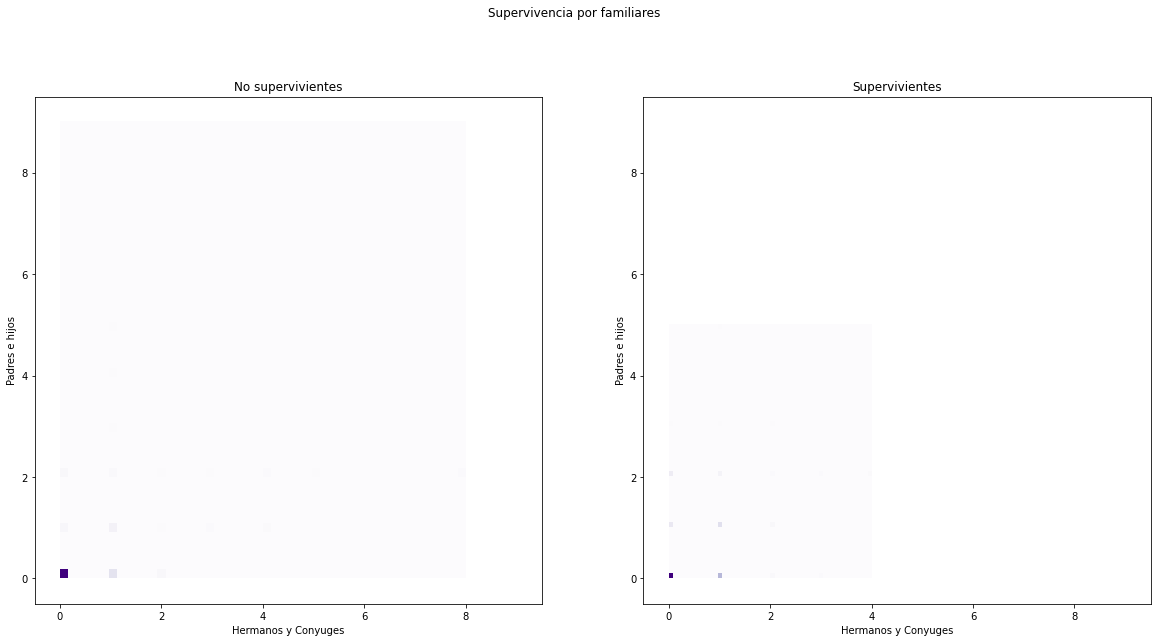

In [171]:
figura = plt.figure(figsize=(20,10))
figura.suptitle('Supervivencia por familiares')

hermanos_padres = datos[['sibsp', 'Parch', 'Survived']]

hermanos_padres_no_superviv = hermanos_padres.mask(hermanos_padres.Survived == 1).dropna()
hermanos_padres_si_superviv = hermanos_padres.mask(hermanos_padres.Survived == 0).dropna()

hueco = figura.add_subplot(1,2,1)

heatmap, xedges, yedges = np.histogram2d(hermanos_padres_no_superviv.sibsp, hermanos_padres_no_superviv.Parch, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
hueco.imshow(heatmap.T, extent=extent, origin='lower', cmap='Purples')
hueco.set_title('No supervivientes')
hueco.set_xlabel('Hermanos y Conyuges')
hueco.set_ylabel('Padres e hijos')
hueco.set_xlim(-0.5,9.5)
hueco.set_ylim(-0.5,9.5)

hueco = figura.add_subplot(1,2,2)
heatmap, xedges, yedges = np.histogram2d(hermanos_padres_si_superviv.sibsp, hermanos_padres_si_superviv.Parch, bins=50)
extent = [xedges[0] , xedges[-1], yedges[0], yedges[-1]]
hueco.imshow(heatmap.T, extent=extent, origin='lower', cmap='Purples')
hueco.set_title('Supervivientes')
hueco.set_xlabel('Hermanos y Conyuges')
hueco.set_ylabel('Padres e hijos')
hueco.set_xlim(-0.5,9.5)
hueco.set_ylim(-0.5,9.5)

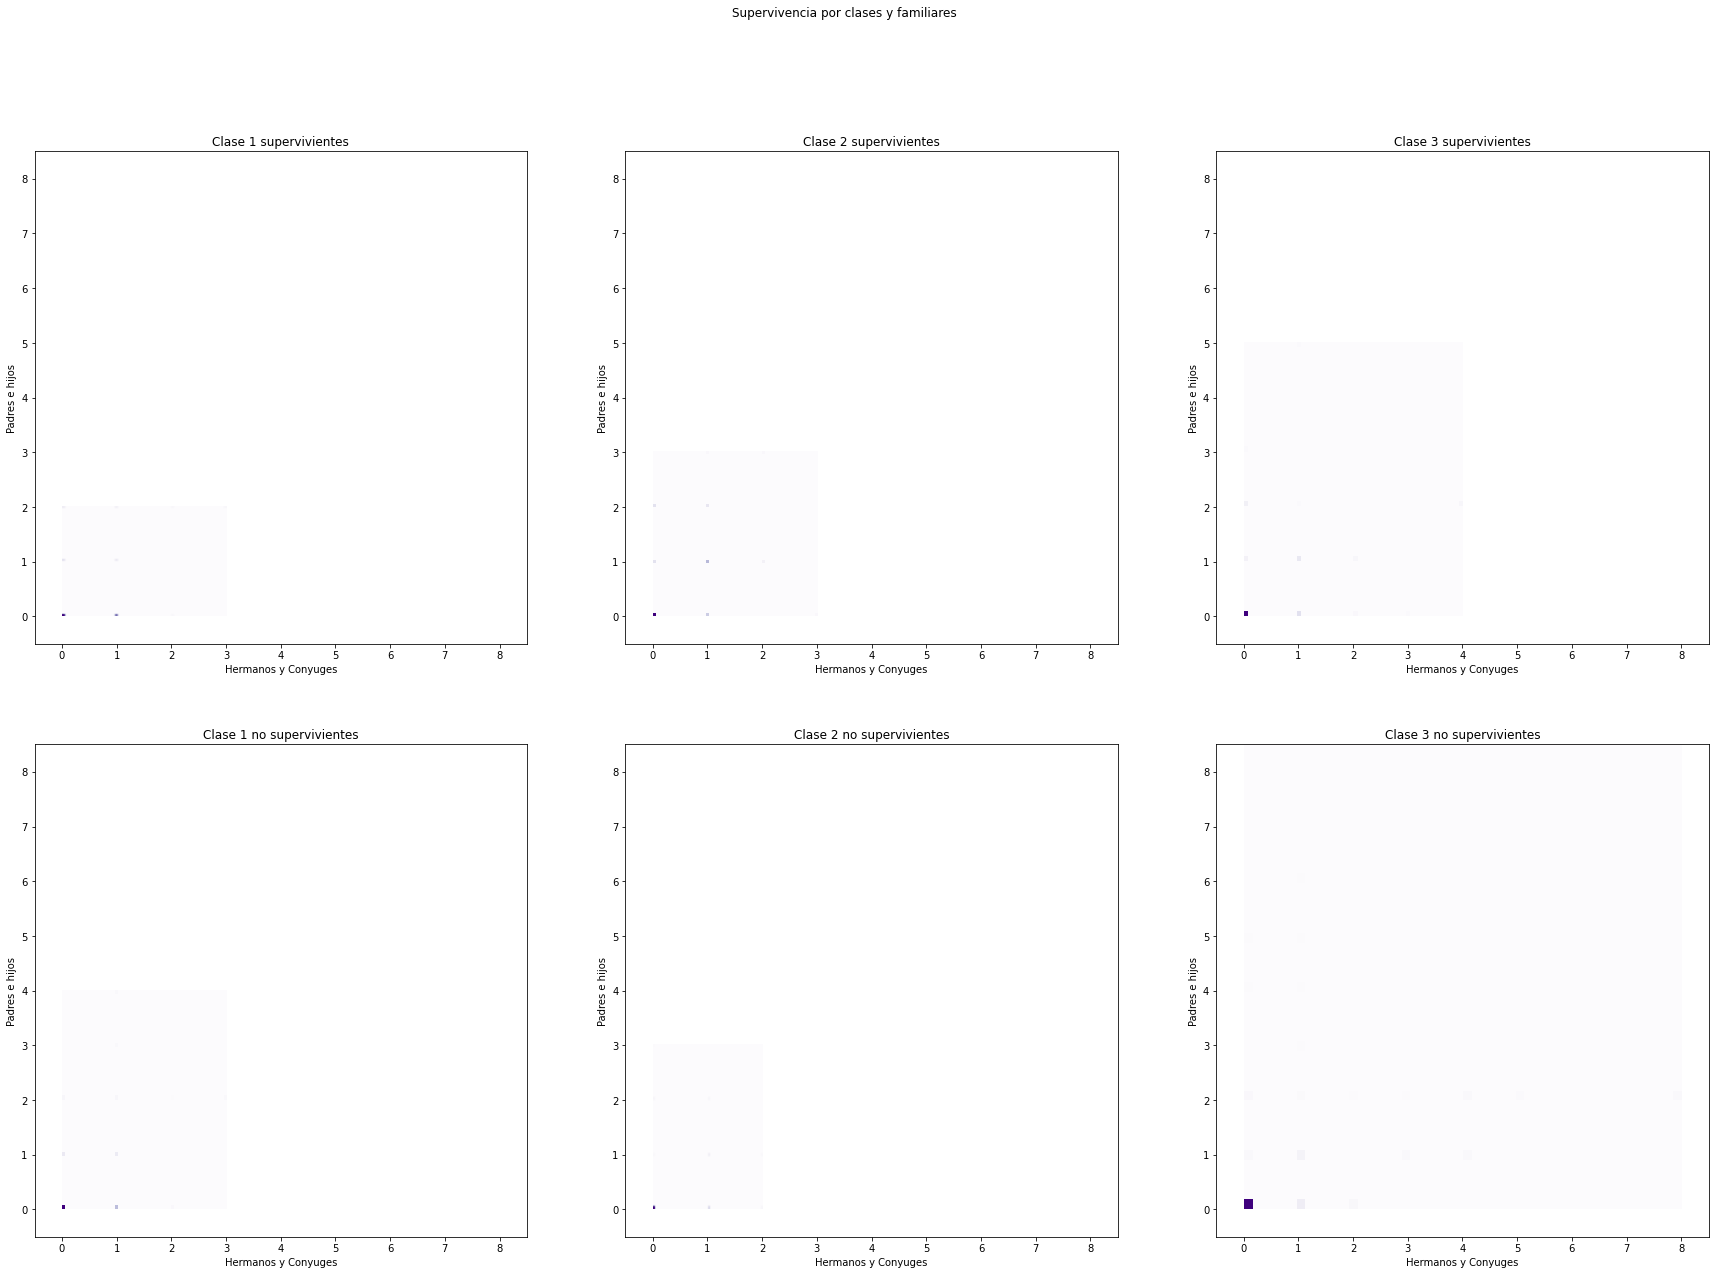

In [172]:
def calcula_familiares(datos, clase, figura):

    hermanos_padres = datos[['sibsp', 'Parch', 'Survived']].mask(datos.Pclass != clase).dropna()

    hermanos_padres_no_superviv = hermanos_padres.mask(hermanos_padres.Survived == 1).dropna()
    hermanos_padres_si_superviv = hermanos_padres.mask(hermanos_padres.Survived == 0).dropna()

    hueco = figura.add_subplot(2,3,clase)
    hueco.set_title(f'Clase {clase} supervivientes')
    heatmap, xedges, yedges = np.histogram2d(hermanos_padres_si_superviv.sibsp, hermanos_padres_si_superviv.Parch, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    hueco.imshow(heatmap.T, extent=extent, origin='lower', cmap='Purples')
    hueco.set_xlabel('Hermanos y Conyuges')
    hueco.set_ylabel('Padres e hijos')
    hueco.set_xlim(-0.5,8.5)
    hueco.set_ylim(-0.5,8.5)

    hueco = figura.add_subplot(2,3,3+clase)
    hueco.set_title(f'Clase {clase} no supervivientes')
    heatmap, xedges, yedges = np.histogram2d(hermanos_padres_no_superviv.sibsp, hermanos_padres_no_superviv.Parch, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    hueco.imshow(heatmap.T, extent=extent, origin='lower', cmap='Purples')
    hueco.set_xlabel('Hermanos y Conyuges')
    hueco.set_ylabel('Padres e hijos')
    hueco.set_xlim(-0.5,8.5)
    hueco.set_ylim(-0.5,8.5)


figura = plt.figure(figsize=(30,20))
figura.suptitle('Supervivencia por clases y familiares')

calcula_familiares(datos, 1, figura)
calcula_familiares(datos, 2, figura)
calcula_familiares(datos, 3, figura)

In [173]:
datos.sibsp.value_counts().sort_index()

0    891
1    319
2     42
3     20
4     22
5      6
8      9
Name: sibsp, dtype: int64

In [174]:
datos.Parch.value_counts().sort_index()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: Parch, dtype: int64

Estos datos son irrelevantes, ya que sólo podemos concluir que en 3era clase iban algunas familas grandes, de más de 4 hermanos, pero estas familias son muy escasas y el hecho de que algunos de sus integrantes se salven puede ser sólo suerte. Y en realidad prácticamente todos los tripulantes iban sólos.

Como esta dimensión no es relevante, queda excluida.

### 0.2.3 Visualizar precio, embarque y clase por supervivencia.

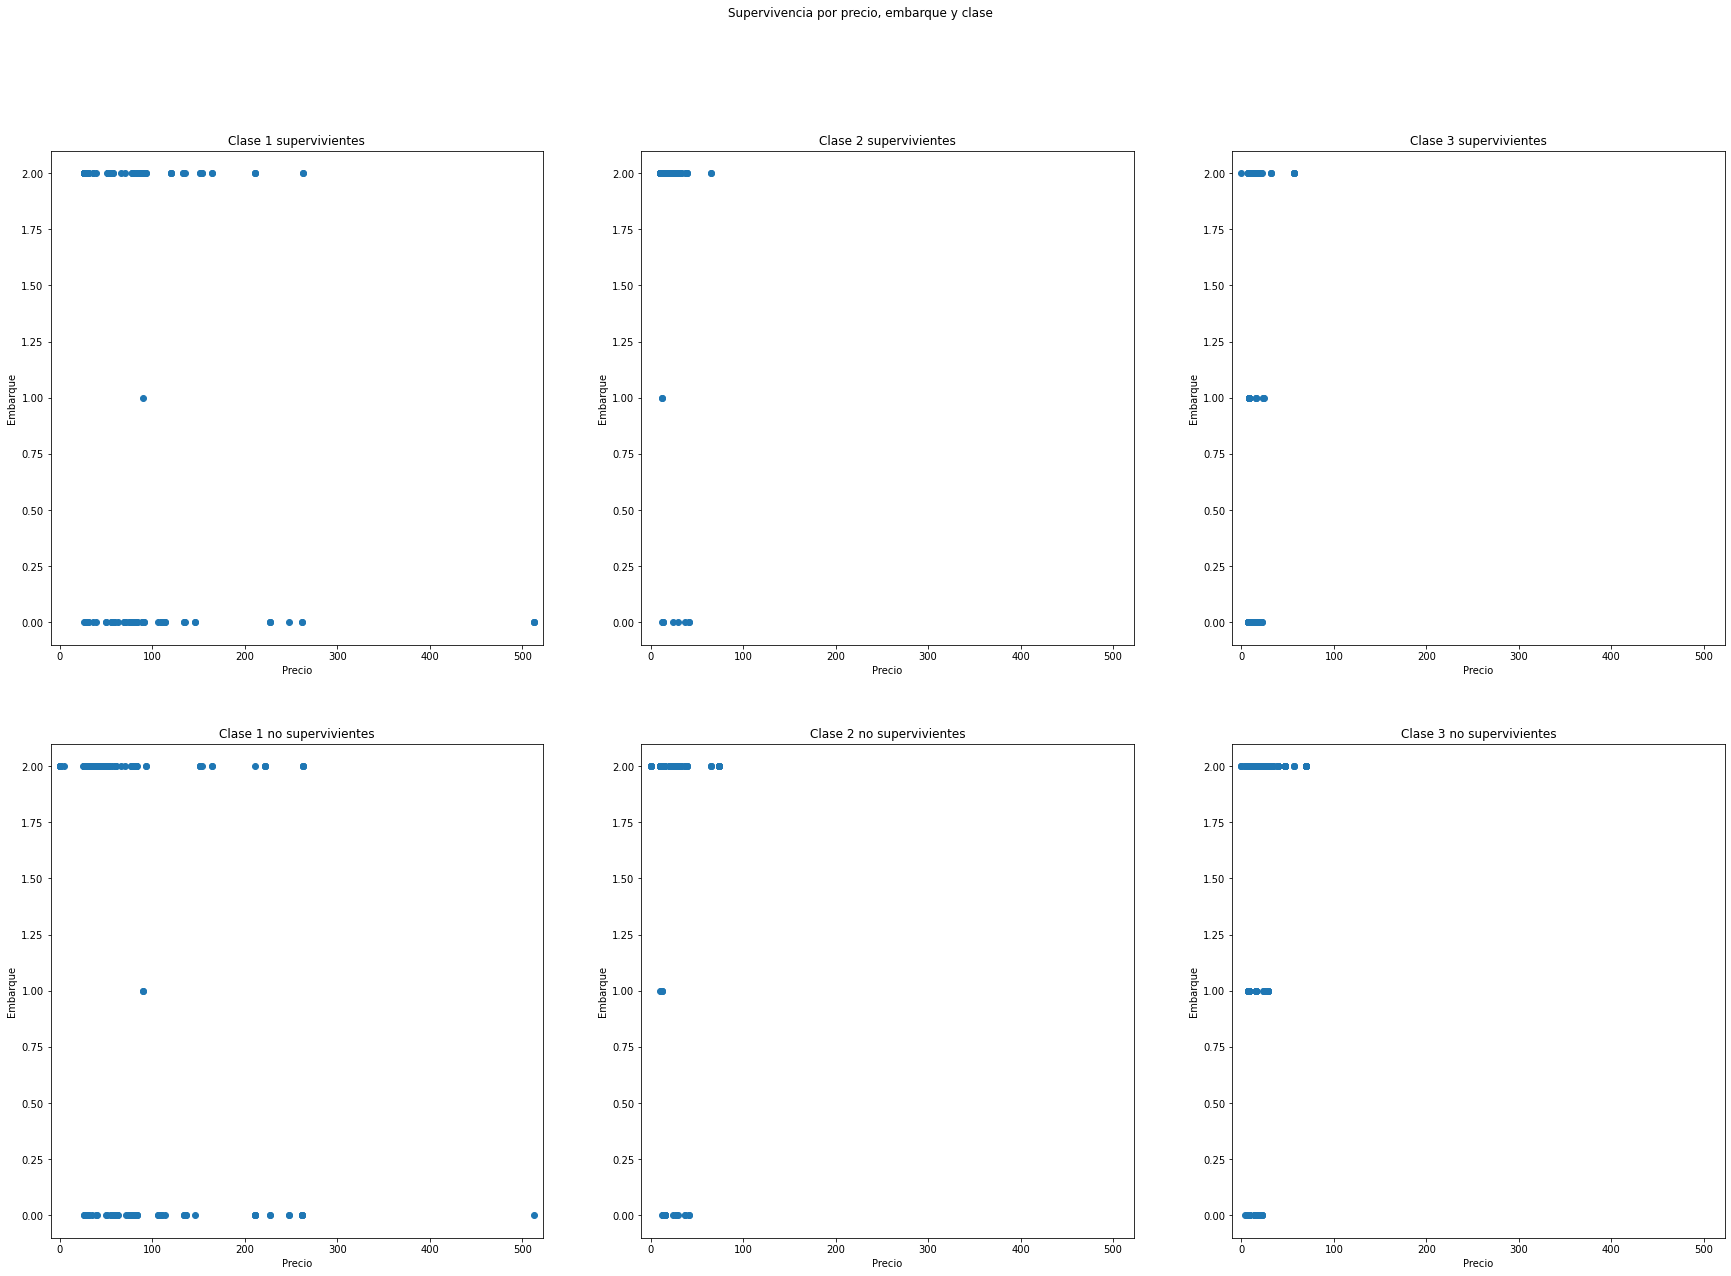

In [175]:
def calcula_precio_embarque(datos, clase, figura):

    precio_embarque = datos[['Fare', 'Embarked', 'Survived']].mask(datos.Pclass != clase).dropna()

    precio_embarque_no_superviv = precio_embarque.mask(precio_embarque.Survived == 1).dropna()
    precio_embarque_si_superviv = precio_embarque.mask(precio_embarque.Survived == 0).dropna()

    hueco = figura.add_subplot(2,3,clase)
    hueco.set_title(f'Clase {clase} supervivientes')
    hueco.scatter(precio_embarque_si_superviv.Fare, precio_embarque_si_superviv.Embarked)
    hueco.set_ylim(-0.1,datos.Embarked.max() + 0.1)
    hueco.set_xlim(-10,datos.Fare.max() + 10)
    hueco.set_xlabel('Precio')
    hueco.set_ylabel('Embarque')

    hueco = figura.add_subplot(2,3,clase + 3)
    hueco.set_title(f'Clase {clase} no supervivientes')
    hueco.scatter(precio_embarque_no_superviv.Fare, precio_embarque_no_superviv.Embarked)
    hueco.set_ylim(-0.1,datos.Embarked.max() + 0.1)
    hueco.set_xlim(-10,datos.Fare.max() + 10)
    hueco.set_xlabel('Precio')
    hueco.set_ylabel('Embarque')


figura = plt.figure(figsize=(30,20))
figura.suptitle('Supervivencia por precio, embarque y clase')

calcula_precio_embarque(datos, 1, figura)
calcula_precio_embarque(datos, 2, figura)
calcula_precio_embarque(datos, 3, figura)

Estos datos son irrelevantes, sólo podemos concluir que la 1era y 2da clase embarcaron en el puerto 2, y que pagaron un precio muy diferente a los de 3era clase, que embarcaron en todos los puertos.

Como estos datos son básicamente las clases, quedan excluidos.

In [176]:
del figura, hermanos_padres, hermanos_padres_no_superviv, hermanos_padres_si_superviv, hombr_superviv, hombr_total, hueco, mujer_superviv, mujer_total, piramide, x_loc, y_loc
del calcula_piramide, calcula_familiares, calcula_precio_embarque

## 0.3 Quitar las columnas que no son útiles, y/o redundantes.

In [177]:
datos = datos.drop(['Fare', 'sibsp', 'Parch', 'Embarked'], axis=1)
datos.describe()

,Age,Sex,Pclass,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.503186,0.355997,2.294882,0.261268
std,12.905241,0.478997,0.837836,0.439494
min,0.170000,0.000000,1.000000,0.000000
25%,22.000000,0.000000,2.000000,0.000000
50%,28.000000,0.000000,3.000000,0.000000
75%,35.000000,1.000000,3.000000,1.000000
max,80.000000,1.000000,3.000000,1.000000


## 0.4 Normalizar en 0 a 1 y onehot

### 0.4.1 Normalizar de 0 a 1 en la misma columna

In [178]:
datos_0_a_1 = datos.copy()
datos_0_a_1.Age = datos_0_a_1.Age.apply(lambda x : x / datos.Age.max())
datos_0_a_1.Pclass = datos_0_a_1.Pclass.apply(lambda x : x / datos.Pclass.max())
datos_0_a_1

,Age,Sex,Pclass,Survived
0,0.27500,0,1.000000,0
1,0.47500,1,0.333333,1
2,0.32500,1,1.000000,1
3,0.43750,1,0.333333,1
4,0.43750,0,1.000000,0
...,...,...,...,...
1304,0.35000,0,1.000000,0
1305,0.48750,1,0.333333,0
1306,0.48125,0,1.000000,0
1307,0.35000,0,1.000000,0


### 0.4.2 Normalizar en onehot

In [179]:
datos_onehot = pd.get_dummies(datos_0_a_1, columns = ['Sex', 'Pclass'])
datos_onehot = datos_onehot.rename({
    'Sex_0':'Hombre', 
    'Sex_1':'Mujer',
    'Pclass_0.3333333333333333' : '1era clase',
    'Pclass_0.6666666666666666' : '2nda clase',
    'Pclass_1.0' : '3ra clase'
    }, axis=1)

datos_onehot

,Age,Survived,Hombre,Mujer,1era clase,2nda clase,3ra clase
0,0.27500,0,1,0,0,0,1
1,0.47500,1,0,1,1,0,0
2,0.32500,1,0,1,0,0,1
3,0.43750,1,0,1,1,0,0
4,0.43750,0,1,0,0,0,1
...,...,...,...,...,...,...,...
1304,0.35000,0,1,0,0,0,1
1305,0.48750,0,0,1,1,0,0
1306,0.48125,0,1,0,0,0,1
1307,0.35000,0,1,0,0,0,1


## 0.5 Separar datos.

### 0.5.0 Función separar_datos y clase Conjunto_Datos

Función para separar en 60% entrenamiento, 10% validación y 30% prueba y en x_datos e y_datos, todo autocontenido en Conjunto_Datos.

De esa forma, solo necesitamos un Conjunto_Datos por normalización.

In [180]:
class Conjunto_Datos:
    x_train = None
    x_vali = None
    x_test = None
    y_train = None
    y_vali = None
    y_test = None
    forma_entrada = None

def separar_datos(datos, train = .6, vali = .1, test = .3, verboso = 1, raiz = 5):
    assert train + vali + test == 1

    ptrain_vali, pvali= int(datos.shape[0] * (train + vali)), int(datos.shape[0] * vali)

    # Separamos los datos en train + vali y test
    _train, _test = train_test_split(datos, train_size = ptrain_vali, random_state = raiz)

    # Separamos train y vali
    _vali, _train = train_test_split(_train, train_size = pvali, random_state= raiz)

    assert _train.shape[0] + _vali.shape[0] + _test.shape[0] == datos.shape[0]

    x_train = _train.drop('Survived', axis=1)
    y_train = _train[['Survived']]

    x_vali = _vali.drop('Survived', axis=1)
    y_vali = _vali[['Survived']]

    x_test = _test.drop('Survived', axis=1)
    y_test = _test[['Survived']]

    if verboso > 0 :
        print('Entrenamiento', '%.2f' % (_train.shape[0] / datos.shape[0]))
        print('Validación',  '%.2f' % (_vali.shape[0]  / datos.shape[0]))
        print('Prueba',  '%.2f' % (_test.shape[0]  / datos.shape[0]))
        print('\nFormas de los datos:')
        print('x_train', x_train.shape)
        print('y_train', y_train.shape)
        print('x_vali', x_vali.shape)
        print('y_vali', y_vali.shape)
        print('x_test', x_test.shape)
        print('y_test', y_test.shape)


    datos = Conjunto_Datos()
    datos.x_train = x_train
    datos.x_vali = x_vali
    datos.x_test = x_test
    datos.y_train = y_train
    datos.y_vali = y_vali
    datos.y_test = y_test
    datos.forma_entrada = (x_train.shape[1],)

    return datos

### 0.5.1 Separar los datos


In [181]:
datos_original = separar_datos(datos)

Entrenamiento 0.60
Validación 0.10
Prueba 0.30

Formas de los datos:
x_train (786, 3)
y_train (786, 1)
x_vali (130, 3)
y_vali (130, 1)
x_test (393, 3)
y_test (393, 1)


In [182]:
datos_0_a_1 = separar_datos(datos_0_a_1, verboso = 0)
datos_onehot = separar_datos(datos_onehot, verboso = 0)
del datos

### 0.5.2 Verificar que en los 3 conjuntos hay personas de todos los tipos.

In [183]:
print('train')
display(datos_original.x_train.Sex.value_counts())
display(datos_original.x_train.Pclass.value_counts())
display(datos_original.y_train.Survived.value_counts())


print('\nvali')
display(datos_original.x_vali.Sex.value_counts())
display(datos_original.x_vali.Pclass.value_counts())
display(datos_original.y_vali.Survived.value_counts())

print('\ntest')
display(datos_original.x_test.Sex.value_counts())
display(datos_original.x_test.Pclass.value_counts())
display(datos_original.y_test.Survived.value_counts())

train


0    512
1    274
Name: Sex, dtype: int64

3    426
1    198
2    162
Name: Pclass, dtype: int64

0    587
1    199
Name: Survived, dtype: int64


vali


0    81
1    49
Name: Sex, dtype: int64

3    64
2    35
1    31
Name: Pclass, dtype: int64

0    93
1    37
Name: Survived, dtype: int64


test


0    250
1    143
Name: Sex, dtype: int64

3    219
1     94
2     80
Name: Pclass, dtype: int64

0    287
1    106
Name: Survived, dtype: int64

# 1. Pruebas para la selección de la topología y normalización.

## 1.0 Crear las clases Modelo, Conjunto_Modelos, y función crear_modelo.

Para la selección de topología, vamos a usar relu para las capas internas y tanh para la capa externa.

Vamos a probar con modelos de 1 a 15 capas, en forma de piramide, sin ser un número par.

Los vamos a entrenar 10 epocas con x_datos_train, y a evaluar sobre y_datos_test.

La función crear_modelo calcula una distribución piramidal de capas, empezando por 2 y multiplicando el anterior por 2, la última capa será siempre 1, solo se aceptan valores impares, y crea un modelo acorde usando los valores de entrada.

Esta función es externa de Conjunto_modelos para poder crear modelos fuera del framework si fuese necesaro.

Ejemplo:

    Para num_capas = 3, se crea un modelo con capas [2, 4, 1]
    Para num_capas = 7, se crea un modelo con capas [2, 4, 8, 16, 8, 4, 1]

In [184]:
class Modelo:
    def __init__(self, num_capas, tipo_datos, raiz_modelos='modelos/', semilla = 5,  forma_entrada=(3,), act_interna=('relu', 'relu'), act_externa=('sigmoid','sigmoid'), optimizador=('adam','adam'), f_coste=('mse','mse')):        
        assert num_capas >= 1 and num_capas % 2

        self.num_capas = num_capas
        self.tipo_datos = tipo_datos
        self.raiz_modelos = raiz_modelos
        self.semilla = semilla
        self.forma_entrada = forma_entrada
        self.act_interna = act_interna
        self.act_externa = act_externa
        self.optimizador = optimizador
        self.f_coste = f_coste

        self.historial = []
        self.evaluacion = None
        self.modelo = None
        
        self.identificador = '_'.join([str(num_capas), act_interna[0], act_externa[0]])
        
        self.iden_global = '_'.join([self.tipo_datos, str(self.semilla), self.identificador, optimizador[0], f_coste[0]])

    def calcular_capas(self):
            self.capas = []
            n = 2
            for c in range(int(self.num_capas / 2)):
                self.capas.append(n)
                n *= 2
            self.capas += [n] + self.capas[::-1]
            self.capas = self.capas[:-1] + [1]

    
    def construir_modelo(self):
        self.calcular_capas()

        tf.random.set_seed(self.semilla)
        entrada = tf.keras.layers.Input(shape=self.forma_entrada)

        if callable(self.act_interna[1]):
            x = tf.keras.layers.Dense(units=self.capas[0])(entrada)
            x = self.act_interna[1]()(x)
            for capa in self.capas[1:-1]: 
                x = tf.keras.layers.Dense(units=capa)(x)
                x = self.act_interna[1]()(x)

        else:
            x = tf.keras.layers.Dense(units=self.capas[0], activation=self.act_interna[1])(entrada)
            for capa in self.capas[1:-1]: 
                x = tf.keras.layers.Dense(units=capa, activation=self.act_interna[1])(x)


        if callable(self.act_externa[1]):
            x = tf.keras.layers.Dense(units=self.capas[-1])(x)
            salida = self.act_externa[1]()(x)
        else:
            salida = tf.keras.layers.Dense(units=self.capas[-1], activation=self.act_externa[1])(x)

        self.modelo = tf.keras.models.Model(entrada, salida)

        self.modelo.compile(optimizer=self.optimizador[1], loss=self.f_coste[1])

    def entrenar(self, datos, epocas = 10, lote = 32, verboso = 0):        
            if self.historial: return
            self.modelo.fit(datos.x_train, datos.y_train, validation_data = (datos.x_vali, datos.y_vali), epochs=epocas, batch_size=lote, verbose=verboso)
            self.historial = self.modelo.history.history
            self.evaluacion = self.modelo.evaluate(datos.x_test, datos.y_test, batch_size=lote, verbose=verboso)
            
            self.guardar()

    def cargar(self):
        modelos_disco = os.listdir(self.raiz_modelos)

        if not self.iden_global in modelos_disco: 
            return False

        # self.modelo = tf.keras.models.load_model(self.raiz_modelos+self.iden_global+'/modelo.h5') # No lo cargo porque no volvemos a entrenar ni evaluar
        self.historial = json.loads(open(self.raiz_modelos+self.iden_global+'/historial.json', 'r').read())
        self.evaluacion = json.loads(open(self.raiz_modelos+self.iden_global+'/evaluacion.json', 'r').read())

        metadatos = json.loads(open(self.raiz_modelos+self.iden_global+'/metadatos.json', 'r').read())

        self.num_capas = metadatos['num_capas']
        self.tipo_datos = metadatos['tipo_datos']
        self.raiz_modelos = metadatos['raiz_modelos']
        self.semilla = metadatos['semilla']
        self.forma_entrada = metadatos['forma_entrada']
        self.act_interna = metadatos['act_interna']
        self.act_externa = metadatos['act_externa']
        self.optimizador = metadatos['optimizador']
        self.f_coste = metadatos['f_coste']

        return True
    
    def guardar(self):        
        os.makedirs(self.raiz_modelos+self.iden_global, exist_ok=True)
        self.modelo.save(self.raiz_modelos+self.iden_global+'/modelo.h5') # Lo guardo, pero no es necesario porque no volvemos a entrenar ni evaluar
        open(self.raiz_modelos+self.iden_global+'/historial.json', 'w').write(json.dumps(self.historial))
        open(self.raiz_modelos+self.iden_global+'/evaluacion.json', 'w').write(json.dumps(self.evaluacion))        

        metadatos = {        
        'num_capas' : self.num_capas,
        'tipo_datos' : self.tipo_datos,
        'raiz_modelos' : self.raiz_modelos,
        'semilla' : self.semilla,
        'forma_entrada' : self.forma_entrada,
        'act_interna' : self.act_interna,
        'act_externa' : self.act_externa,
        'optimizador' : self.optimizador,
        'f_coste' : self.f_coste,
        }
        
        open(self.raiz_modelos+self.iden_global+'/metadatos.json', 'w').write(json.dumps(metadatos))        


La clase Conjunto_Modelos contiene toda la información necesaria para hacer las pruebas, así como los modelos, y todas las funciones para crearlos, entrenarlos, mutarlos y evaluarlos.

In [185]:
class Conjunto_Modelos:

    '''
    La clase se inicializa recibiendo conjuntos_datos, lo cual se espera que sea un diccionario con este formato:

    {'identificador_tipo_datos': datos}

    A su vez, datos es una instancia de Conjunto_Datos con estos atributos:

        x_train
        x_vali
        x_test
        y_train
        y_vali
        y_test
        forma_entrada
    '''
    def __init__(self, conjuntos_datos={}, raiz_modelos='modelos/'):
        assert isinstance(conjuntos_datos, dict)
        self.conjuntos_datos = conjuntos_datos
        self.raiz_modelos = raiz_modelos
        self.modelos = {}
        self.fs_coste = []
        self.optimizadores = []
        self.activaciones_externas = []
        self.activaciones_internas = []
        os.makedirs(self.raiz_modelos, exist_ok=True)

    def crear_modelos(self, tipo_datos, semillas = [5], min_capas=1, max_capas=16, act_interna=('relu', 'relu'), act_externa=('sigmoid','sigmoid'), optimizador=('adam','adam'), f_coste=('mse','mse')):
        assert tipo_datos in self.conjuntos_datos.keys()
        assert min_capas > 0 and max_capas > min_capas
        assert min_capas % 2 and not max_capas % 2

        capas = list(range(min_capas, max_capas, 2))

        self.fs_coste += [f_coste[0]]
        self.fs_coste = list(set(self.fs_coste))

        self.optimizadores += [optimizador[0]]
        self.optimizadores = list(set(self.optimizadores))

        n = 0

        for num_capas in capas:
            for semilla in semillas:
                print(f'Creando modelos {tipo_datos}, {n+1} de {len(capas)*len(semillas)}', end = '\r')
                modelo = Modelo(num_capas, tipo_datos, semilla = semilla, forma_entrada=self.conjuntos_datos[tipo_datos].forma_entrada, act_interna=act_interna, act_externa=act_externa, optimizador=optimizador, f_coste=f_coste)

                if modelo.iden_global in self.modelos.keys(): continue
                if not modelo.cargar(): modelo.construir_modelo()

                self.modelos[modelo.iden_global] = modelo

                n += 1

        print()

    def entrenar_modelos(self, epocas=10, lote=32, verboso=0):
        assert self.modelos
        assert epocas > 0 and lote > 0

        for n, modelo in enumerate(self.modelos.values()):
            porcen = ((n) * 100) / len(self.modelos)
            print(f'Entrenando modelo {n+1} de {len(self.modelos)} ({"%.2f" % porcen}%)' , end='\r')

            datos = self.conjuntos_datos[modelo.tipo_datos]
            modelo.entrenar(datos, epocas=epocas, lote=lote, verboso=verboso)

        print(f'Entrenando modelo {n+1} de {len(self.modelos)} (100.00%)' , end='\r')

        print()

    def cargar_todos(self):
        self.modelos = {}

        for indice in os.listdir(self.raiz_modelos):
            indice = indice.split('_')
            num_capas = int(indice[2])
            tipo_datos = indice[0]
            semilla = int(indice[1])
            act_interna = (indice[3],indice[3])
            act_externa = (indice[4],indice[4])
            optimizador = (indice[5],indice[5])
            f_coste = (indice[6],indice[6])
            modelo = Modelo(num_capas, tipo_datos, semilla = semilla, forma_entrada=self.conjuntos_datos[tipo_datos].forma_entrada, act_interna=act_interna, act_externa=act_externa, optimizador=optimizador, f_coste=f_coste)
            try:
                modelo.cargar()
            except Exception as e:
                print(e)
                print(indice)
                break
            self.modelos[modelo.iden_global] = modelo


    def mejores_modelos(self, cantidad=3):
        assert cantidad > 0

        lista = list(self.modelos.values())

        '''
            modelo.evaluacion es [perdida, evaluación]
            Si no tiene metrica, evaluación es perdida, siendo [perdida, perdida]
            y el ranking se genera ordenando por evaluaciones, y luego por perdidas
        '''
        lista.sort(key=lambda x: x.evaluacion)

        lista_final = []

        for n, modelo in enumerate(lista[:cantidad]):
            f_coste = modelo.f_coste[0]
            optimizador = modelo.optimizador[0]

            lista_final.append((n + 1, modelo.tipo_datos, modelo.semilla,  modelo.identificador, optimizador, f_coste, modelo.evaluacion, modelo.iden_global))

        return lista_final

    def ranking(self, cantidad = 10):
        mejores = pruebas_modelos.mejores_modelos(cantidad)
        mejores = [n[:-1] for n in mejores]
        print(tabulate(mejores, headers = ['Ranking',  'Normalizado', 'Semilla', 'Modelo', 'Optimizador', 'F. Coste', 'Evaluación (pérdida test)']))

    def descartar_no_en_mejores(self, cantidad = 3):
        modelos = list(self.modelos.values())
        mejores = self.mejores_modelos(cantidad=cantidad)
        for modelo in modelos:
            encontrado = False
            for mejor in mejores:
                if modelo.iden_global == mejor[-1]:
                    encontrado = True
                    break

            if encontrado: continue

            self.modelos.pop(modelo.iden_global)

    def _dibuja_en_hueco(self, hueco, titulo, epocas, entrenamiento, validacion, y_max_real, y_min_real):
        hueco.set_title(titulo)
        hueco.set_xlabel('Epocas')
        hueco.set_ylabel('Perdida')

        if not entrenamiento: return  y_max_real, y_min_real

        entrenamiento = np.array(entrenamiento)
        validacion = np.array(validacion)

        entrenamiento = entrenamiento[~np.isnan(entrenamiento).any(axis=1)]
        validacion = validacion[~np.isnan(validacion).any(axis=1)]

        if not entrenamiento.any(): return  y_max_real, y_min_real

        entrenamiento_maximos = np.max(entrenamiento, axis=0)
        entrenamiento_minimos = np.min(entrenamiento, axis=0)
        validacion_maximos = np.max(validacion, axis=0)
        validacion_minimos = np.min(validacion, axis=0)

        hueco.fill_between(epocas, entrenamiento_maximos, entrenamiento_minimos, alpha=0.3, label='Entrenamiento')
        hueco.plot(np.mean(entrenamiento, axis=0), 'b--',label = 'Entr. Promedio')
        hueco.plot(np.median(entrenamiento, axis=0), 'r--',label = 'Entr. Medianas')

        hueco.fill_between(epocas, validacion_maximos, validacion_minimos, color= 'y', alpha=0.3, label='Validación')
        hueco.plot(np.mean(validacion, axis=0), 'g-',label = 'Vali. Promedio')
        hueco.plot(np.median(validacion, axis=0), 'm-',label = 'Vali. Medianas')
        hueco.legend()

        y_max_real = max(y_max_real, max(entrenamiento_maximos))
        y_min_real = min(y_min_real, min(entrenamiento_minimos))

        y_max_real = max(y_max_real, max(validacion_maximos))
        y_min_real = min(y_min_real, min(validacion_minimos))

        return  y_max_real, y_min_real

    def dibuja_perdidas_agrupadas(self):
        assert self.modelos

        y_max_real = 0
        y_min_real = float('inf')
        huecos = []

        epocas = list(self.modelos.values())
        epocas = range(len(epocas[0].historial['loss']))

        figura = plt.figure( figsize=(10 * len(self.conjuntos_datos), 10) )

        for n, tipo_datos in enumerate(self.conjuntos_datos.keys()):
            hueco = figura.add_subplot(1, len(self.conjuntos_datos), n+1)
            huecos.append(hueco)

            entrenamiento = []
            validacion = []

            for modelo in self.modelos.values():
                if not modelo.tipo_datos == tipo_datos: continue
                entrenamiento.append(modelo.historial['loss'])
                validacion.append(modelo.historial['val_loss'])

            y_max_real, y_min_real = self._dibuja_en_hueco(hueco, tipo_datos, epocas, entrenamiento, validacion, y_max_real, y_min_real)

        porcen = y_max_real * 0.1
        y_max_real *= 1.1
        y_min_real -= porcen

        for hueco in huecos:
            hueco.set_ylim(y_min_real, y_max_real)

    def dibuja_perdidas_por_f_coste(self):
        assert self.modelos
        assert self.fs_coste

        figura = plt.figure( figsize=(7 * len(self.conjuntos_datos), 7 * len(self.fs_coste)) )

        y_max_real = 0
        y_min_real = float('inf')
        huecos = []
        epocas = list(self.modelos.values())
        epocas = range(len(epocas[0].historial['loss']))

        n = 1
        for _, f_coste in enumerate(self.fs_coste):
            for _, tipo_datos in enumerate(self.conjuntos_datos.keys()):
                hueco = figura.add_subplot(len(self.fs_coste), len(self.conjuntos_datos), n)
                huecos.append(hueco)
                n += 1

                entrenamiento = []
                validacion = []

                for modelo in self.modelos.values():
                    if not modelo.tipo_datos == tipo_datos: continue
                    if not modelo.f_coste: continue
                    if not modelo.f_coste[0] == f_coste: continue

                    _ = list(modelo.historial.keys())

                    entrenamiento.append(modelo.historial[_[0]])
                    validacion.append(modelo.historial[_[1]])

                y_max_real, y_min_real = self._dibuja_en_hueco(hueco, f'{tipo_datos} - {f_coste}', epocas, entrenamiento, validacion, y_max_real, y_min_real)

        porcen = y_max_real * 0.1
        y_max_real *= 1.1
        y_min_real -= porcen

        for hueco in huecos:
            hueco.set_ylim(y_min_real, y_max_real)

    def dibuja_perdidas_por_optimizador(self):
        assert self.modelos
        assert self.optimizadores

        figura = plt.figure( figsize=(7 * len(self.conjuntos_datos), 7 * len(self.optimizadores)) )

        y_max_real = 0
        y_min_real = float('inf')
        huecos = []
        epocas = list(self.modelos.values())
        epocas = range(len(epocas[0].historial['loss']))

        n = 1
        for _, optimizador in enumerate(self.optimizadores):
            for _, tipo_datos in enumerate(self.conjuntos_datos.keys()):
                hueco = figura.add_subplot(len(self.optimizadores), len(self.conjuntos_datos), n)
                huecos.append(hueco)
                n += 1

                entrenamiento = []
                validacion = []

                for modelo in self.modelos.values():
                    if not modelo.tipo_datos == tipo_datos: continue
                    if not modelo.optimizador: continue
                    if not modelo.optimizador[0] == optimizador: continue

                    _ = list(modelo.historial.keys())

                    entrenamiento.append(modelo.historial[_[0]])
                    validacion.append(modelo.historial[_[1]])

                y_max_real, y_min_real = self._dibuja_en_hueco(hueco, f'{tipo_datos} - {optimizador}', epocas, entrenamiento, validacion, y_max_real, y_min_real)

        porcen = y_max_real * 0.1
        y_max_real *= 1.1
        y_min_real -= porcen

        for hueco in huecos:
            hueco.set_ylim(y_min_real, y_max_real)

    def dibuja_perdidas_por_activacion_externa(self):
        assert self.modelos
        assert self.activaciones_externas

        figura = plt.figure( figsize=(7 * len(self.conjuntos_datos), 7 * len(self.activaciones_externas)) )

        y_max_real = 0
        y_min_real = float('inf')
        huecos = []
        epocas = list(self.modelos.values())
        epocas = range(len(epocas[0].historial['loss']))

        n = 1
        for _, activacion in enumerate(self.activaciones_externas):
            for _, tipo_datos in enumerate(self.conjuntos_datos.keys()):
                hueco = figura.add_subplot(len(self.activaciones_externas), len(self.conjuntos_datos), n)
                huecos.append(hueco)
                n += 1

                entrenamiento = []
                validacion = []

                for modelo in self.modelos.values():
                    if not modelo.tipo_datos == tipo_datos: continue
                    if not modelo.act_externa: continue
                    if not modelo.act_externa[0] == activacion: continue

                    _ = list(modelo.historial.keys())

                    entrenamiento.append(modelo.historial[_[0]])
                    validacion.append(modelo.historial[_[1]])

                y_max_real, y_min_real = self._dibuja_en_hueco(hueco, f'{tipo_datos} - {activacion}', epocas, entrenamiento, validacion, y_max_real, y_min_real)

        porcen = y_max_real * 0.1
        y_max_real *= 1.1
        y_min_real -= porcen

        for hueco in huecos:
            hueco.set_ylim(y_min_real, y_max_real)

    def dibuja_perdidas_por_activacion_interna(self):
        assert self.modelos
        assert self.activaciones_internas

        figura = plt.figure( figsize=(7 * len(self.conjuntos_datos), 7 * len(self.activaciones_internas)) )

        y_max_real = 0
        y_min_real = float('inf')
        huecos = []
        epocas = list(self.modelos.values())
        epocas = range(len(epocas[0].historial['loss']))

        n = 1
        for _, activacion in enumerate(self.activaciones_internas):
            for _, tipo_datos in enumerate(self.conjuntos_datos.keys()):
                hueco = figura.add_subplot(len(self.activaciones_internas), len(self.conjuntos_datos), n)
                huecos.append(hueco)
                n += 1

                entrenamiento = []
                validacion = []

                for modelo in self.modelos.values():
                    if not modelo.tipo_datos == tipo_datos: continue
                    if not modelo.act_interna: continue
                    if not modelo.act_interna[0] == activacion: continue

                    _ = list(modelo.historial.keys())

                    entrenamiento.append(modelo.historial[_[0]])
                    validacion.append(modelo.historial[_[1]])

                y_max_real, y_min_real = self._dibuja_en_hueco(hueco, f'{tipo_datos} - {activacion}', epocas, entrenamiento, validacion, y_max_real, y_min_real)

        porcen = y_max_real * 0.1
        y_max_real *= 1.1
        y_min_real -= porcen

        for hueco in huecos:
            hueco.set_ylim(y_min_real, y_max_real)


    def mutar_modelos_act_externa(self, activaciones):
        modelos_originales = list(self.modelos.values())

        for activacion in activaciones:
            self.activaciones_externas += [activacion[0]]
            for modelo_original in modelos_originales:
                if modelo_original.act_externa == activacion: continue

                modelo_nuevo = Modelo(modelo_original.num_capas,
                    tipo_datos=modelo_original.tipo_datos,
                    semilla = modelo_original.semilla,
                    forma_entrada=self.conjuntos_datos[modelo_original.tipo_datos].forma_entrada,
                    act_interna=modelo_original.act_interna,
                    act_externa=activacion,
                    optimizador=modelo_original.optimizador,
                    f_coste=modelo_original.f_coste,)

                if modelo_nuevo.iden_global in self.modelos.keys(): continue
                if not modelo_nuevo.cargar(): modelo_nuevo.construir_modelo()

                self.modelos[modelo_nuevo.iden_global] = modelo_nuevo
        self.activaciones_externas = list(set(self.activaciones_externas))

    def mutar_modelos_act_interna(self, activaciones):
        modelos_originales = list(self.modelos.values())

        for activacion in activaciones:
            self.activaciones_internas += [activacion[0]]
            for modelo_original in modelos_originales:
                if modelo_original.act_interna == activacion: continue

                modelo_nuevo = Modelo(modelo_original.num_capas,
                    tipo_datos=modelo_original.tipo_datos,
                    semilla = modelo_original.semilla,
                    forma_entrada=self.conjuntos_datos[modelo_original.tipo_datos].forma_entrada,
                    act_interna=activacion,
                    act_externa=modelo_original.act_externa,
                    optimizador=modelo_original.optimizador,
                    f_coste=modelo_original.f_coste,)

                if modelo_nuevo.iden_global in self.modelos.keys(): continue
                if not modelo_nuevo.cargar(): modelo_nuevo.construir_modelo()

                self.modelos[modelo_nuevo.iden_global] = modelo_nuevo
        self.activaciones_internas = list(set(self.activaciones_internas))

    def mutar_modelos_f_coste(self, fs_coste):
        assert isinstance(fs_coste, list)

        modelos_originales = list(self.modelos.values())

        for f_coste in fs_coste:
            self.fs_coste += [f_coste[0]]
            for modelo_original in modelos_originales:
                if modelo_original.f_coste == f_coste: continue

                modelo_nuevo = Modelo(modelo_original.num_capas,
                    tipo_datos=modelo_original.tipo_datos,
                    semilla = modelo_original.semilla,
                    forma_entrada=self.conjuntos_datos[modelo_original.tipo_datos].forma_entrada,
                    act_interna=modelo_original.act_interna,
                    act_externa=modelo_original.act_externa,
                    optimizador=modelo_original.optimizador,
                    f_coste=f_coste)

                if modelo_nuevo.iden_global in self.modelos.keys(): continue
                if not modelo_nuevo.cargar(): modelo_nuevo.construir_modelo()

                self.modelos[modelo_nuevo.iden_global] = modelo_nuevo

        self.fs_coste = list(set(self.fs_coste))

    def mutar_modelos_optimizador(self, optimizadores):
        assert isinstance(optimizadores, list)

        modelos_originales = list(self.modelos.values())

        for optimizador in optimizadores:
            self.optimizadores += [optimizador[0]]
            for modelo_original in modelos_originales:
                if modelo_original.optimizador == optimizador: continue

                modelo_nuevo = Modelo(modelo_original.num_capas,
                    tipo_datos=modelo_original.tipo_datos,
                    semilla = modelo_original.semilla,
                    forma_entrada=self.conjuntos_datos[modelo_original.tipo_datos].forma_entrada,
                    act_interna=modelo_original.act_interna,
                    act_externa=modelo_original.act_externa,
                    optimizador=optimizador,
                    f_coste=modelo_original.f_coste)

                if modelo_nuevo.iden_global in self.modelos.keys(): continue
                if not modelo_nuevo.cargar(): modelo_nuevo.construir_modelo()

                self.modelos[modelo_nuevo.iden_global] = modelo_nuevo

        self.optimizadores = list(set(self.optimizadores))

## 1.1 Entrenar los modelos básicos

De forma predeterminada, se crean los modelos con capas internas  ReLU, la capa externa Sigmoide, Adam y MSE.

Estos modelos se entrenan durante 10 épocas usando el set de train, se evaluan con el de test, y no emplean métricas.

Estos modelos, tienen desde 1 a 15 capas, con forma piramidal y sin ser un número par de capas.

In [186]:
pruebas_modelos = Conjunto_Modelos(
    {
        'Original': datos_original,
        '0 a 1': datos_0_a_1,
        'Onehot': datos_onehot,
    }
)

semillas = [1, 3, 5, 7, 11, 123, 666, 1024]
for tipo_datos in pruebas_modelos.conjuntos_datos.keys():
    pruebas_modelos.crear_modelos(tipo_datos, semillas=semillas, min_capas=1, max_capas=16)

pruebas_modelos.entrenar_modelos()

Creando modelos Original, 64 de 64
Creando modelos 0 a 1, 64 de 64
Creando modelos Onehot, 64 de 64
Entrenando modelo 192 de 192 (100.00%)


## 1.2 Resultados

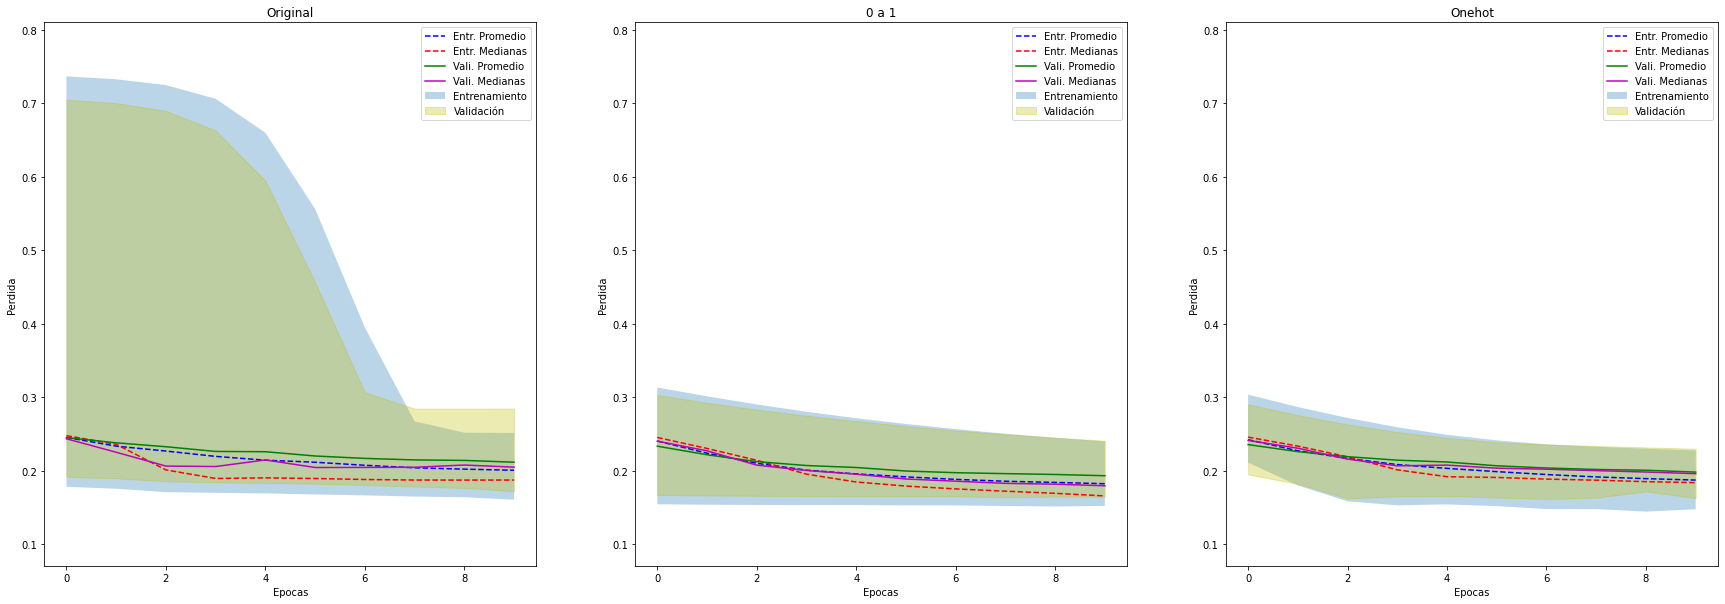

In [187]:
pruebas_modelos.dibuja_perdidas_agrupadas()

Esta gráfica representa las pérdidas de los modelos en entrenamiento y validación, separadas y agrupadas por la normalización empleada.

Es una gráfica sencilla, para ver los valores específicos en el siguiente punto imprimimos un ranking.

In [188]:
pruebas_modelos.ranking()

  Ranking  Normalizado      Semilla  Modelo           Optimizador    F. Coste      Evaluación (pérdida test)
---------  -------------  ---------  ---------------  -------------  ----------  ---------------------------
        1  Onehot               123  13_relu_sigmoid  adam           mse                            0.149996
        2  Onehot               123  15_relu_sigmoid  adam           mse                            0.150015
        3  Onehot               123  9_relu_sigmoid   adam           mse                            0.151605
        4  Onehot               123  11_relu_sigmoid  adam           mse                            0.151677
        5  0 a 1                  3  11_relu_sigmoid  adam           mse                            0.156053
        6  0 a 1                  5  11_relu_sigmoid  adam           mse                            0.156096
        7  0 a 1                  7  1_relu_sigmoid   adam           mse                            0.156535
        8  Onehot  

## 1.3 Conclusiones

Respecto a la gráfica, podemos observar que no normalizar los datos (tipo original), crea modelos con pérdida muy superior en las primeras épocas respecto a los que sí estan normalizados, además de que la validación deja de mejorar en la época 6, aún así, en las últimas épocas los resultados son similares entre todos los tipos de normalización.

Respecto al ranking, de los 10 mejores, el 50% son Onehot y la otra mitad 0 a 1, no aparecen sin normalizar.

Había predicho en el punto 0.2.1 que la normalizacion 0 a 1 iba a ser más útil, pero Onehot la supera por menos de 0.01, están empatados en 0.15.

Para las siguientes pruebas vamos a descartar los modelos que no aparezcan en el top 3, ya que si tenemos demasiados las pruebas se hacen muy largas, y la diferencia entre ellos es baja.

Casualmente los 3 mejores que pasarán son Onehot y semilla 123.

# 2. Pruebas para la selección de función de coste.

## 2.1 Mutación, y entrenamiento

Vamos a probar todas las funciones  relevantes que vienen con keras.

Hay muchas más, pero son enfocadas a multiclase, imágenes, multidimensiones, y no interesan.

In [189]:
fs_coste = [
    # Probabilisticas
    ('binary crossentropy', 'binary_crossentropy'),
    # ('categorical crossentropy', 'categorical_crossentropy'), # -> Da nulos
    # ('sparse categorical crossentropy', 'sparse_categorical_crossentropy'), # -> Da nulos
    
    # Regresión Logística
    ('mse', 'mse'),
    ('mae', 'mae'),
]

In [190]:
pruebas_modelos.descartar_no_en_mejores()

In [191]:
pruebas_modelos.mutar_modelos_f_coste(fs_coste)
pruebas_modelos.entrenar_modelos()

Entrenando modelo 9 de 9 (100.00%)


## 2.2 Resultados

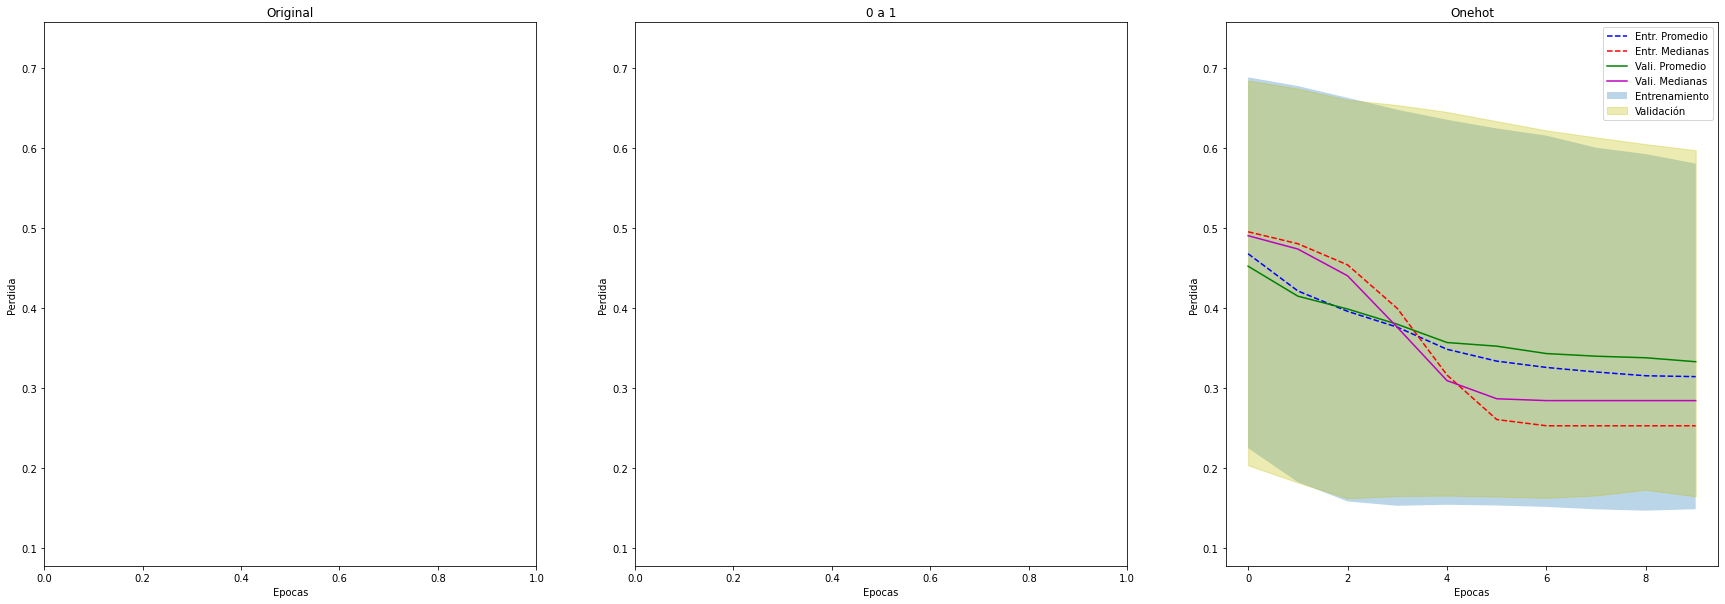

In [192]:
pruebas_modelos.dibuja_perdidas_agrupadas()

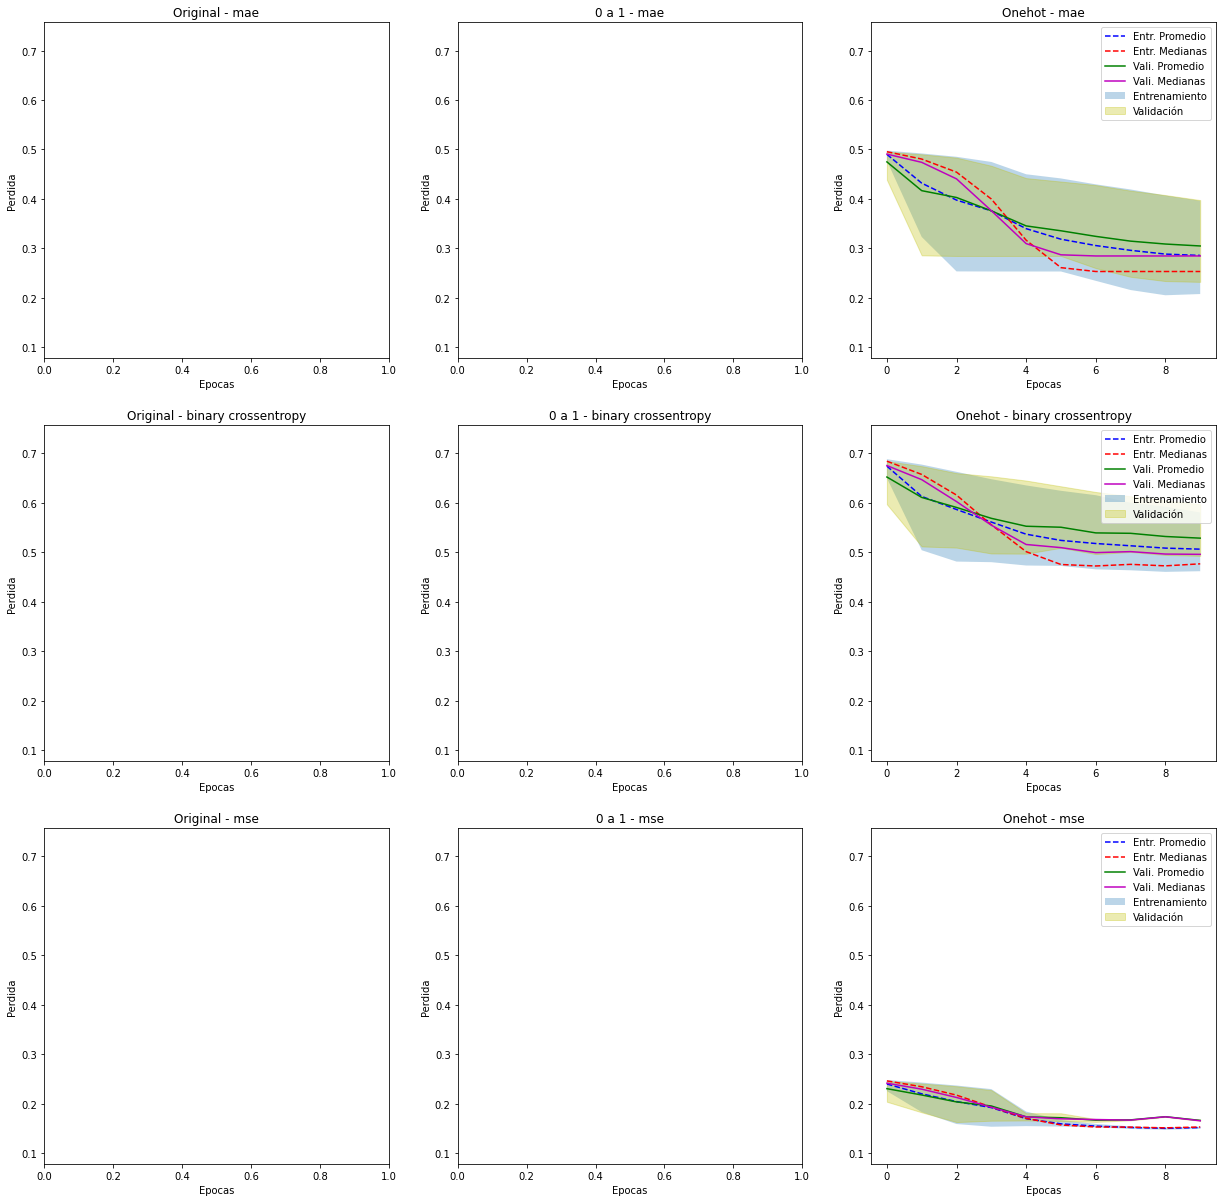

In [193]:
pruebas_modelos.dibuja_perdidas_por_f_coste()

In [194]:
pruebas_modelos.ranking(50)

  Ranking  Normalizado      Semilla  Modelo           Optimizador    F. Coste               Evaluación (pérdida test)
---------  -------------  ---------  ---------------  -------------  -------------------  ---------------------------
        1  Onehot               123  13_relu_sigmoid  adam           mse                                     0.149996
        2  Onehot               123  15_relu_sigmoid  adam           mse                                     0.150015
        3  Onehot               123  9_relu_sigmoid   adam           mse                                     0.151605
        4  Onehot               123  9_relu_sigmoid   adam           mae                                     0.204649
        5  Onehot               123  13_relu_sigmoid  adam           mae                                     0.269723
        6  Onehot               123  15_relu_sigmoid  adam           mae                                     0.384725
        7  Onehot               123  9_relu_sigmoid   ad

## 2.3 Conclusiones

Respecto a la gráfica de pérdidas agrupadas, vemos que las nuevas redes tienen pérdidas muy diversas, o eso parece.

Las que están en la parte más baja de la gráfica, hacen un sobreajuste, lo vemos porque sube la validación.

Respecto a la gráfica pérdidas por función de coste, las más altas es binary crossentropy, lo cual tiene sentido porque está diseñado para imágenes.

MAE es mucho peor que mse, y lo demuestra porque sus redes tienen valores muy dispersos.

Respecto al ranking, las mejores redes son las que ya teníamos, que eran MSE, así que esas sobreviven.

# 3. Pruebas para la selección de algoritmo de optimización.


## 3.1 Seleccion de algoritmo de optimización.

Vamos a probar todos los optimizadores que vienen con keras. 

In [195]:
optimizadores = [
    ('sgd', 'sgd'),
    ('rmsprop', 'rmsprop'),
    ('adam', 'adam'),
    ('adadelta', 'adadelta'),
    ('adagrad', 'adagrad'),
    ('adamax', 'adamax'),
    ('nadam', 'nadam'),
    ('ftrl', 'ftrl'),
]

In [196]:
pruebas_modelos.descartar_no_en_mejores()

In [197]:
pruebas_modelos.mutar_modelos_optimizador(optimizadores)
pruebas_modelos.entrenar_modelos()

Entrenando modelo 24 de 24 (100.00%)


## 3.2 Resultados

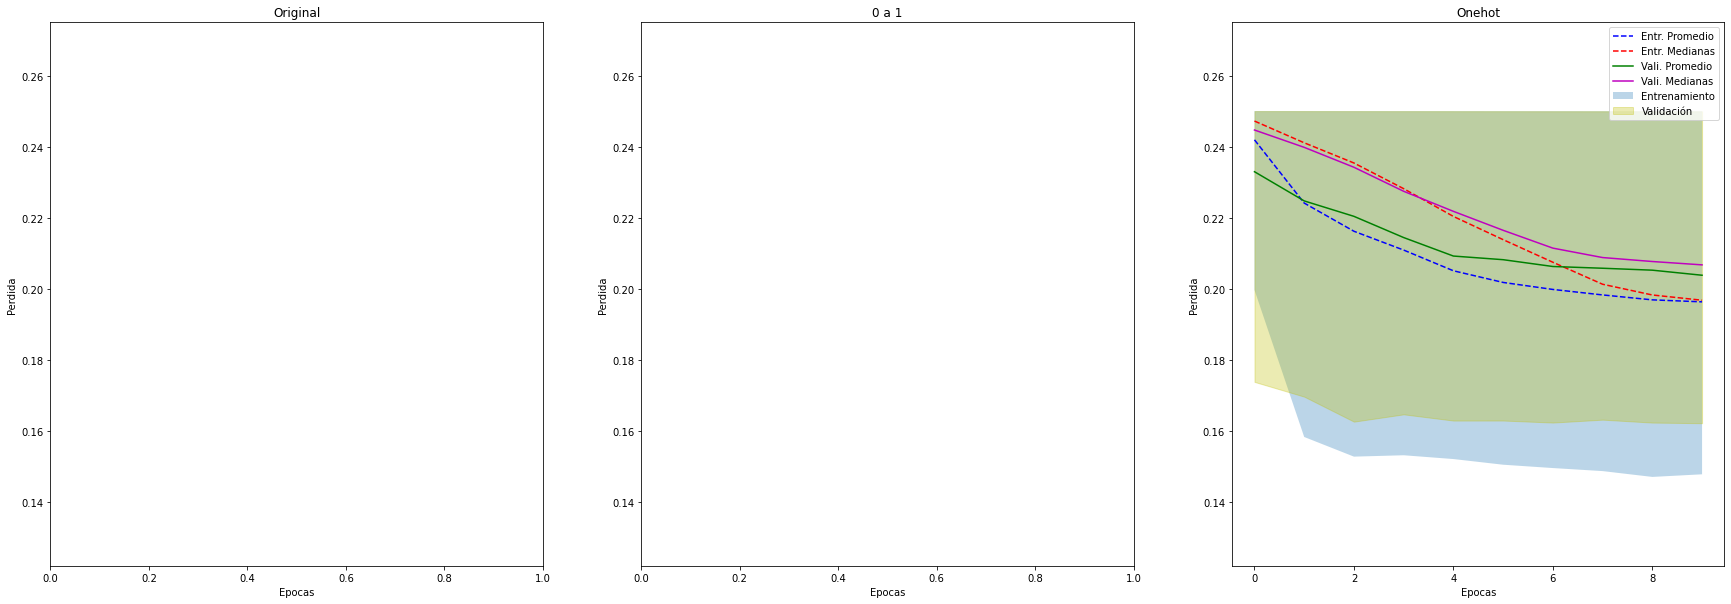

In [198]:
pruebas_modelos.dibuja_perdidas_agrupadas()

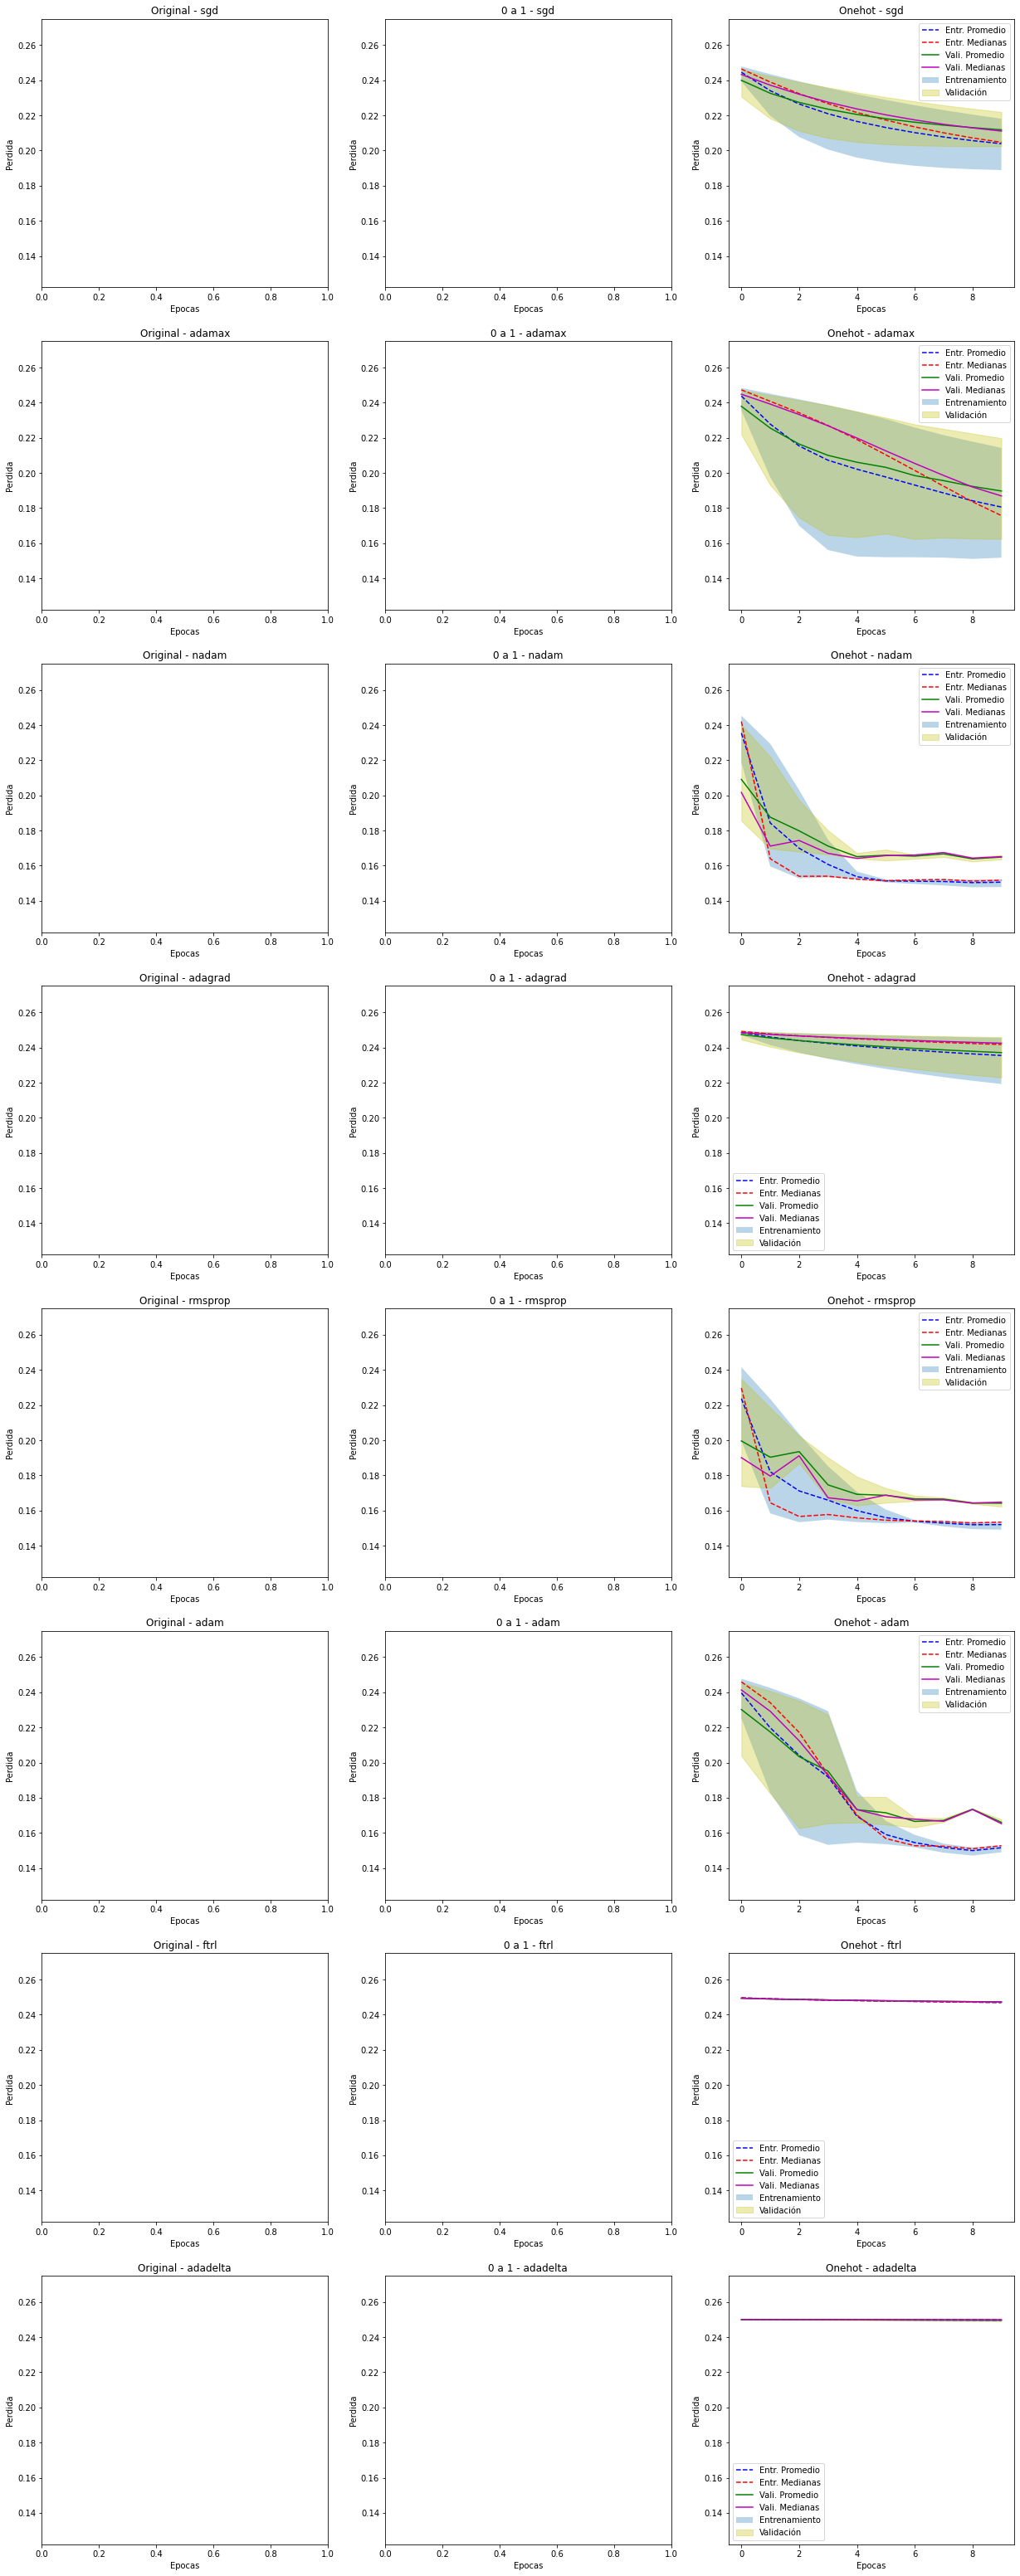

In [199]:
pruebas_modelos.dibuja_perdidas_por_optimizador()

In [200]:
pruebas_modelos.ranking(50)

  Ranking  Normalizado      Semilla  Modelo           Optimizador    F. Coste      Evaluación (pérdida test)
---------  -------------  ---------  ---------------  -------------  ----------  ---------------------------
        1  Onehot               123  15_relu_sigmoid  rmsprop        mse                            0.149345
        2  Onehot               123  13_relu_sigmoid  nadam          mse                            0.149466
        3  Onehot               123  13_relu_sigmoid  adamax         mse                            0.149593
        4  Onehot               123  13_relu_sigmoid  adam           mse                            0.149996
        5  Onehot               123  15_relu_sigmoid  adam           mse                            0.150015
        6  Onehot               123  15_relu_sigmoid  nadam          mse                            0.150233
        7  Onehot               123  9_relu_sigmoid   rmsprop        mse                            0.150417
        8  Onehot  

## 3.3 Conclusiones

Respecto a las pérdidas agrupadas, vemos que la influencia del optimizador es muy grande, ya que algunas no mejoran, y otras tienen sobreajuste.

Respecto a la gráfica de pérdidas por optimizador, hay algunos como adamax, que tienen mucha variabilidad, y otros  como adadelta o ftrl, que no varían nada, yo considero que en ambos casos eso es algo malo, ya que pueden no llegar o "se pasan de frenada".

Aún así, adamax entra en el top 3 

# 4. Pruebas para la selección de activación externa.

## 4.1 Selección de activación externa.

Descarto los modelos que no estén en el top 3, y los del top 3 se vuelven a crear usando otra activación, se entrenan y lo visualizamos.

In [201]:
pruebas_modelos.descartar_no_en_mejores()

Empleamos algunas de las activaciones que vienen con keras.

Yo preveo que la mejor va ser sigmoid, y que es un problema de clasificación binaria sobre 0 o 1, y sigmoid da buenos resultados en estos casos.

In [202]:
activaciones = [
    ('sigmoid', 'sigmoid'),
    ('relu','relu'),
    ('swish','swish'),
    ('linear','linear'),
    ('softmax','softmax'),
    ('selu','selu'),
    ('tanh','tanh'),
    # ('leakyrelu',tf.keras.layers.LeakyReLU), # --> Conjunto_Modelos ya no admite funciones, solo strings
    # ('prelu',tf.keras.layers.PReLU),
    # ('elu',tf.keras.layers.ELU),
    # ('thresholdedrelu',tf.keras.layers.ThresholdedReLU),
]

In [203]:
pruebas_modelos.mutar_modelos_act_externa(activaciones)
pruebas_modelos.entrenar_modelos()

Entrenando modelo 21 de 21 (100.00%)


## 4.2 Resultados

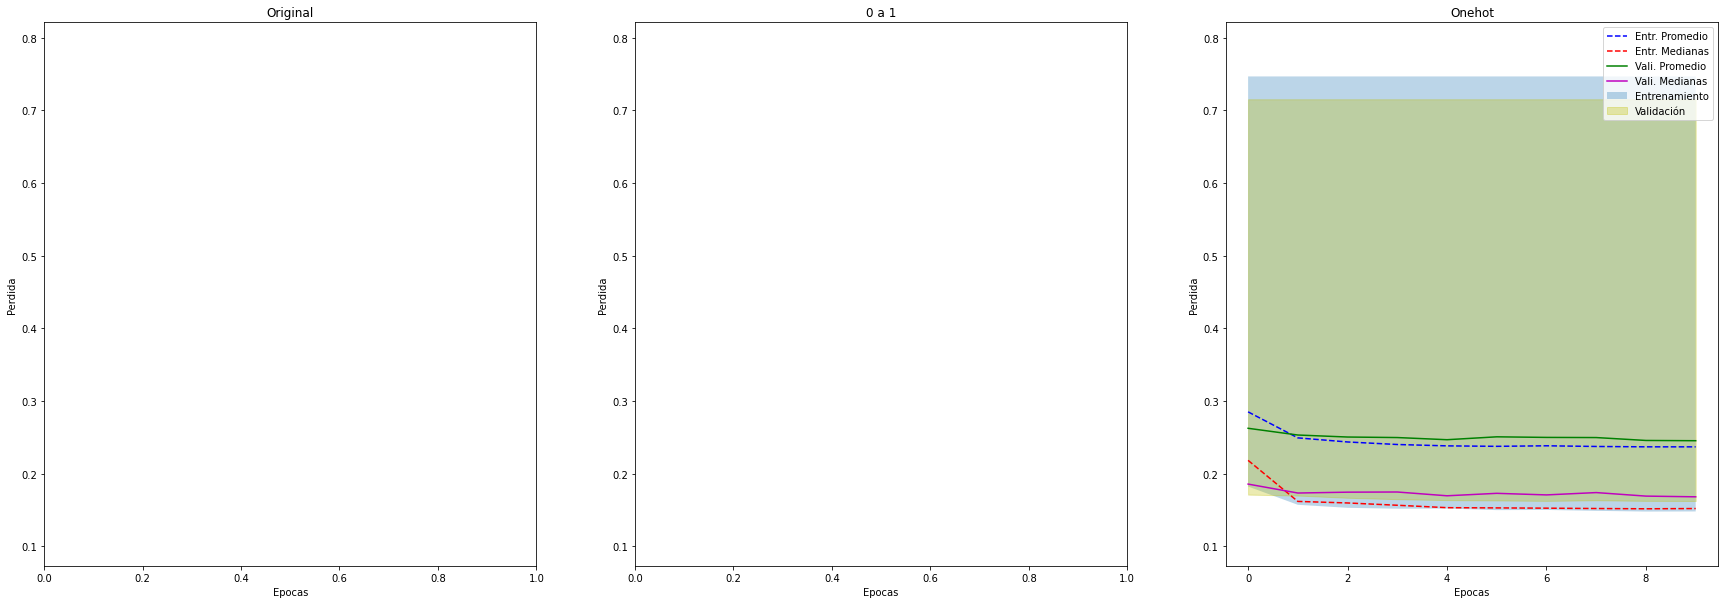

In [204]:
pruebas_modelos.dibuja_perdidas_agrupadas()

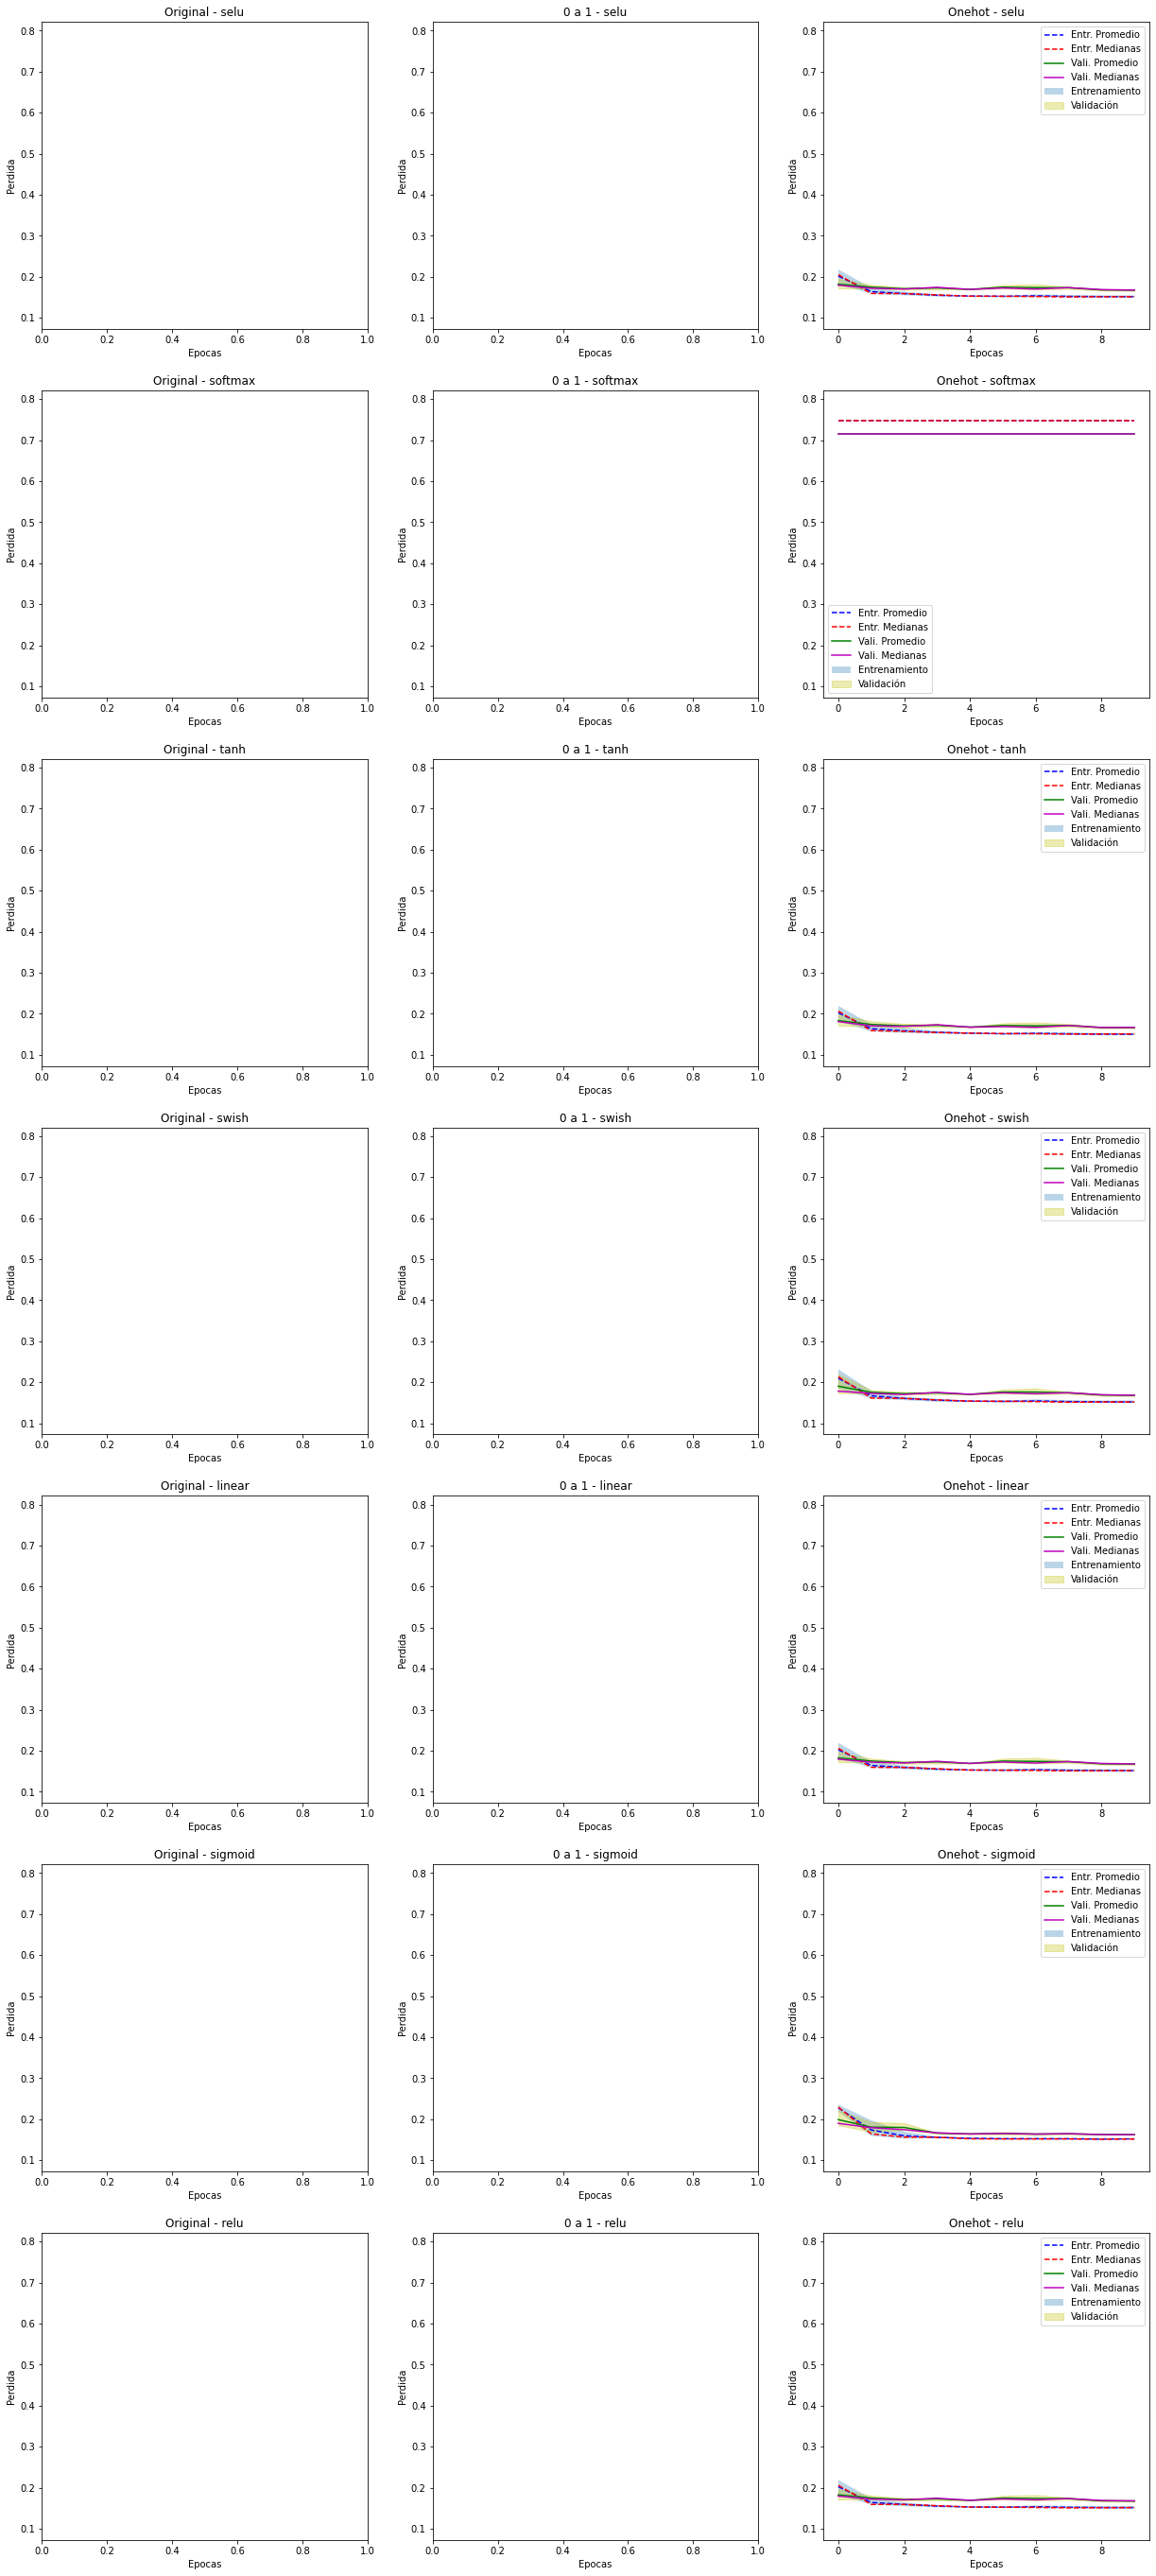

In [205]:
pruebas_modelos.dibuja_perdidas_por_activacion_externa()

In [206]:
pruebas_modelos.ranking()

  Ranking  Normalizado      Semilla  Modelo           Optimizador    F. Coste      Evaluación (pérdida test)
---------  -------------  ---------  ---------------  -------------  ----------  ---------------------------
        1  Onehot               123  15_relu_sigmoid  rmsprop        mse                            0.149345
        2  Onehot               123  13_relu_sigmoid  nadam          mse                            0.149466
        3  Onehot               123  13_relu_sigmoid  adamax         mse                            0.149593
        4  Onehot               123  13_relu_tanh     adamax         mse                            0.1497
        5  Onehot               123  13_relu_tanh     nadam          mse                            0.150292
        6  Onehot               123  15_relu_tanh     rmsprop        mse                            0.150462
        7  Onehot               123  13_relu_linear   adamax         mse                            0.150606
        8  Onehot    

## 4.3 Conclusiones

Respecto a la gráfica de pérdidas agrupadas, la selección de la activación externa es muy importante y esta grafica demuestra como varía el rendimiento, aunque, realmente esta gráfica es una mentira, porque la red con los valores más altos es softmax, las demás tienen rendimientos mucho mejores.

Respecto a el ranking y la gráfica de pérdidas por activación, están todas muy empatadas en 0.14 y 0.15, la mejor es sigmoid, como he predicho, me sorprende tanh con tan buena puntuación, ya que ésta deberia dar solo -1 o 1, debe de estar valorandola muy bien porque hay más 1s en el target que 0s

# 5 Pruebas para la selección de activación en capas internas.

## 5.1 Selección de activación interna

Realizamos la misma operación, pero con las capas internas.

Preveo que en este caso la mejor será relu, o linear, ya que no hay valores negativos de entrada y los valores son lineales.

In [207]:
pruebas_modelos.descartar_no_en_mejores()

In [208]:
pruebas_modelos.mutar_modelos_act_interna(activaciones)
pruebas_modelos.entrenar_modelos()

Entrenando modelo 21 de 21 (100.00%)


## 5.2 Resultados

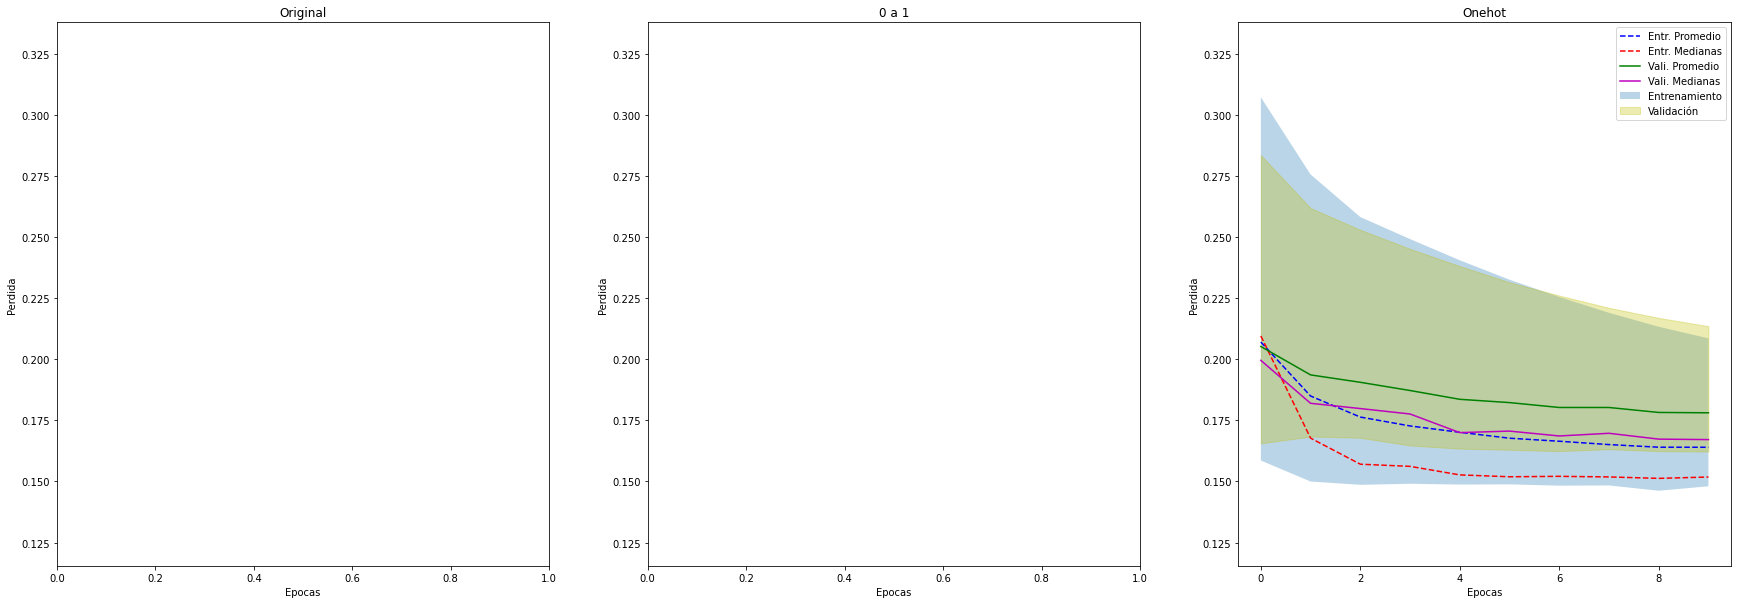

In [209]:
pruebas_modelos.dibuja_perdidas_agrupadas()

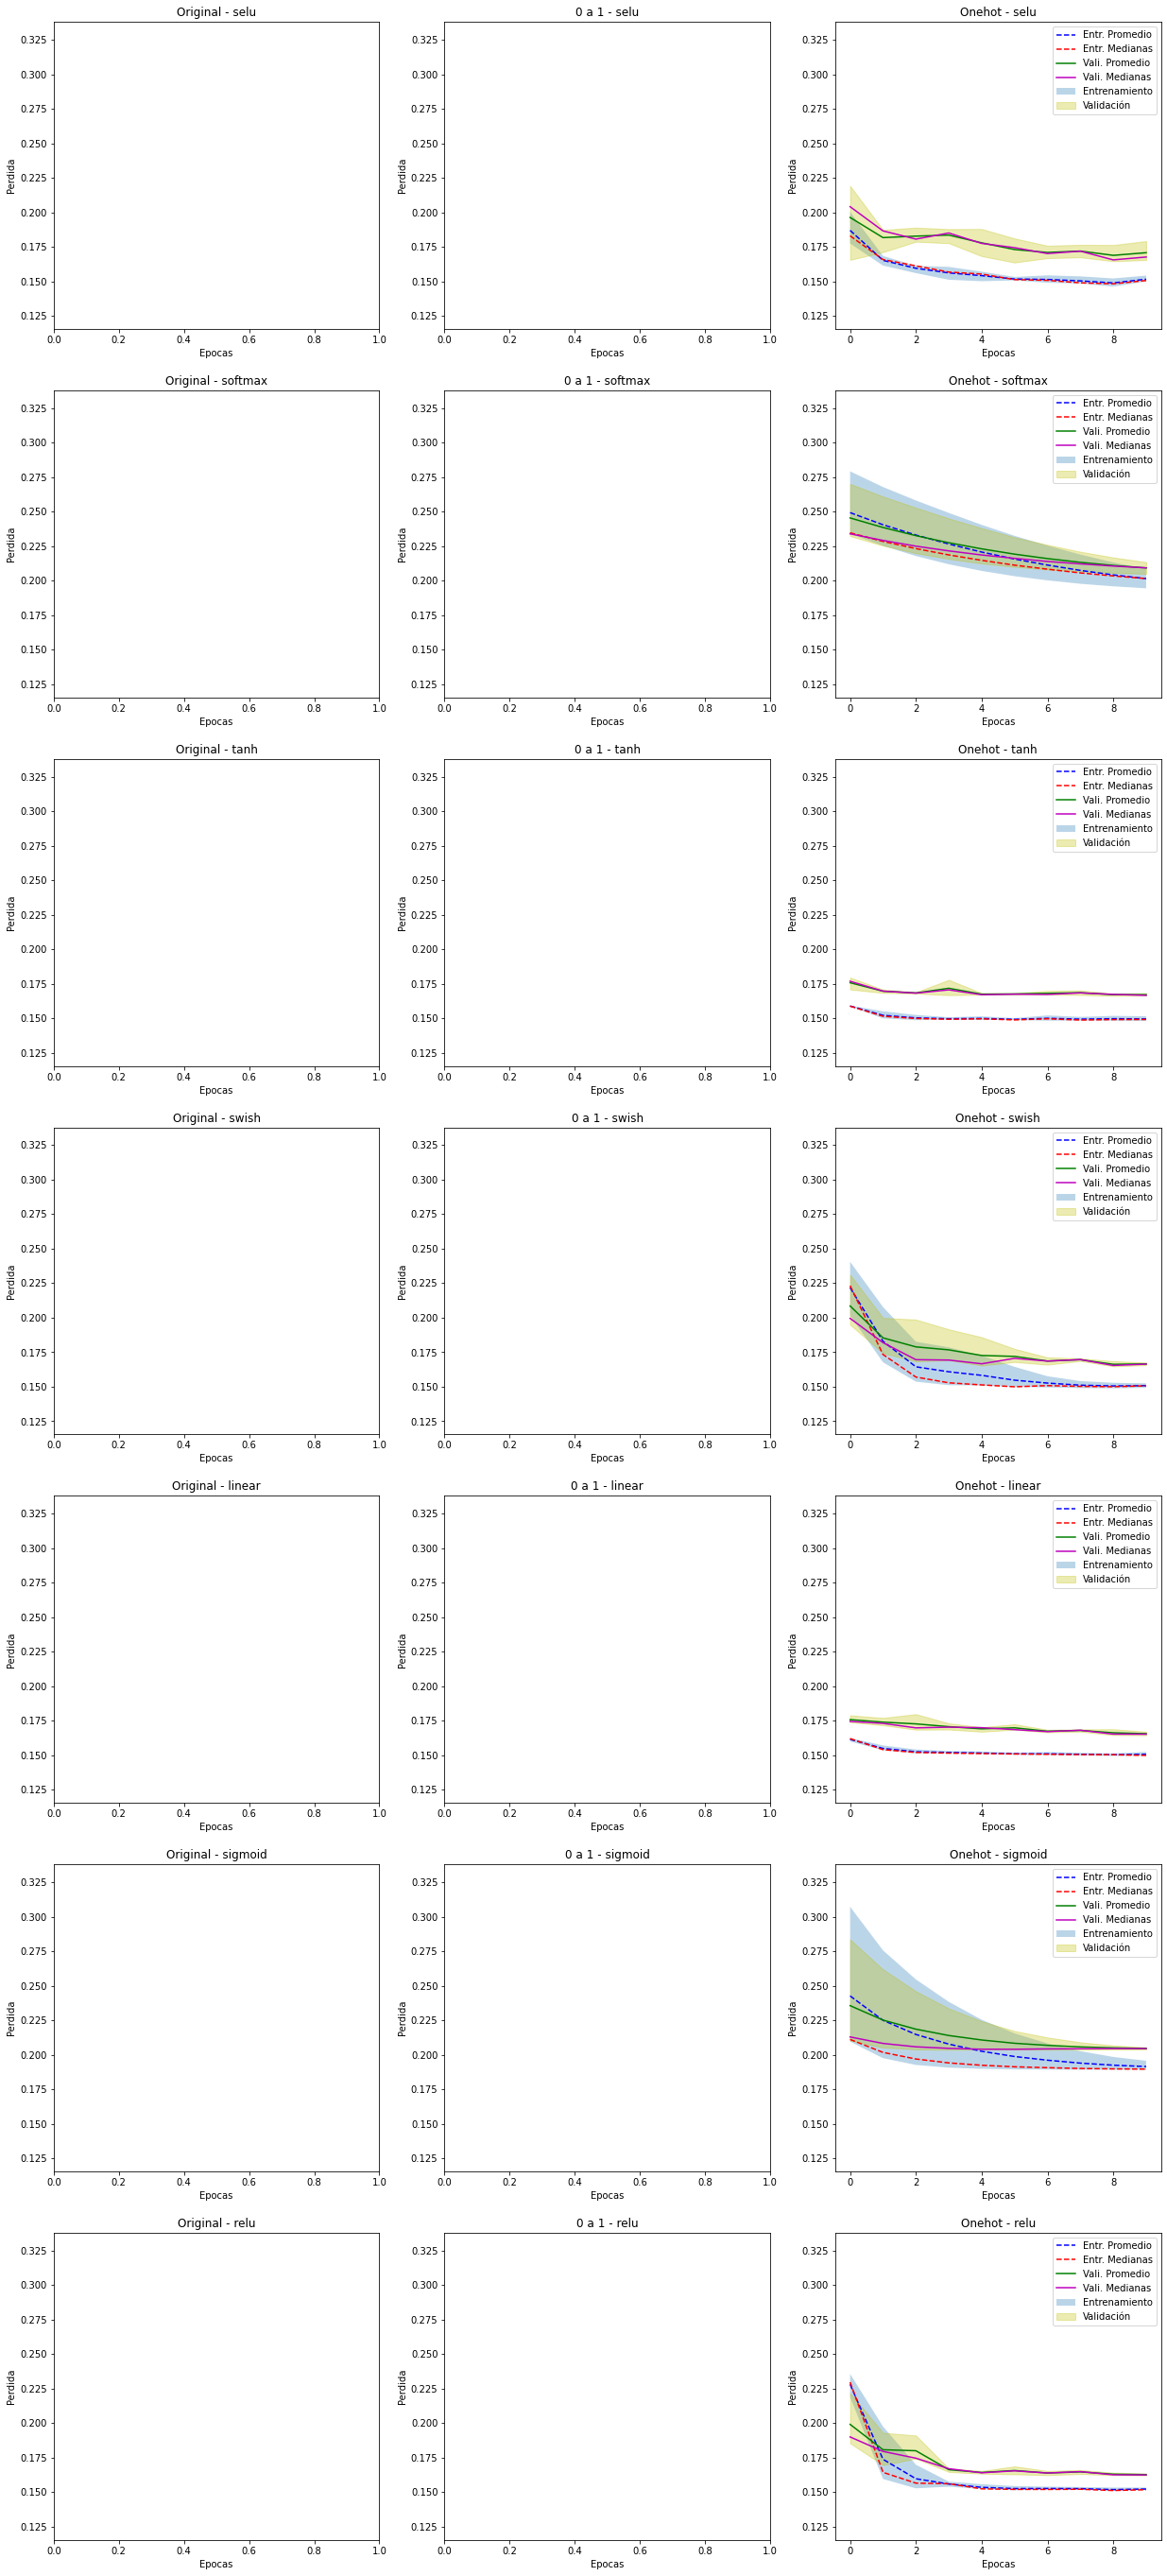

In [210]:
pruebas_modelos.dibuja_perdidas_por_activacion_interna()

In [211]:
pruebas_modelos.ranking()

  Ranking  Normalizado      Semilla  Modelo             Optimizador    F. Coste      Evaluación (pérdida test)
---------  -------------  ---------  -----------------  -------------  ----------  ---------------------------
        1  Onehot               123  15_relu_sigmoid    rmsprop        mse                            0.149345
        2  Onehot               123  13_relu_sigmoid    nadam          mse                            0.149466
        3  Onehot               123  13_relu_sigmoid    adamax         mse                            0.149593
        4  Onehot               123  13_swish_sigmoid   nadam          mse                            0.150817
        5  Onehot               123  13_linear_sigmoid  nadam          mse                            0.151774
        6  Onehot               123  15_linear_sigmoid  rmsprop        mse                            0.15211
        7  Onehot               123  15_swish_sigmoid   rmsprop        mse                            0.152723
  

## 5.3 Conclusiones

Respecto a la gráfica agrupada, en este caso también tenemos mucha variabilidad de rendimiento según la activación, pero ahora si que es verdad no como en el caso anterior

Respecto a las gráficas, en algunos casos como relu, o swish ha habido un sobreajuste en las primeras épocas, pero por lo general todas tienen una buena curva de descenso.

Respecto al ranking, la mejor es relu y linear, como hemos predicho, junto a una swish, en general están todas las del top 10 bastante empatadas con el anterior top 10, y la mejora no es muy notable.

# 6 Resultados y conclusiones del proyecto

Tal y como comentaba en la estrategia, el cubo que hemos explorado tenía la siguiente forma:

- 3 Tipos de normalizacion
- 8 Semillas
- 8 Arquitecturas de red
- 3 Funciones de coste
- 8 Optimizadores
- 7 Activaciones de capa externa
- 7 Activaciones de capa interna

Esto son 3 x 8 x 8 x 3 x 8 x 7 x 7, combinaciones posibles, es decir, 225.792 en total, del los cuales sólo hemos tenido que generar y entrenar 255 modelos, lo cual representa el 0.1129% de todas esas posibilidades, si entrenar un modelo tarda, por ejemplo, 7 segundos, haber iterado por todas las posibilidades hubiera supuesto 18 días, 7 horas y 12 minutos aproximadamente.

Estos son los 3 mejores:

In [212]:
pruebas_modelos.ranking(3)

  Ranking  Normalizado      Semilla  Modelo           Optimizador    F. Coste      Evaluación (pérdida test)
---------  -------------  ---------  ---------------  -------------  ----------  ---------------------------
        1  Onehot               123  15_relu_sigmoid  rmsprop        mse                            0.149345
        2  Onehot               123  13_relu_sigmoid  nadam          mse                            0.149466
        3  Onehot               123  13_relu_sigmoid  adamax         mse                            0.149593


Cabe destacar, que son ReLU para las capas internas y Sigmoid para la externa, lo cual no sorprende, ya que no habia datos negativos de entrada, los datos eran lineales, y era un problema de clasificación binaria.

Lo que si me sorprende es que adam no esté en el ranking, ya que el puesto 2 y 3 son variaciones suyas.

Si los comparamos con el top 3 de los modelos "básicos", creados en el punto 1.1

    Ranking  Normalizado      Semilla  Modelo           Optimizador    F. Coste      Evaluación (pérdida test)
    ---------  -------------  ---------  ---------------  -------------  ----------  ---------------------------
            1  Onehot               123  13_relu_sigmoid  adam           mse                            0.149996
            2  Onehot               123  15_relu_sigmoid  adam           mse                            0.150015
            3  Onehot               123  9_relu_sigmoid   adam           mse                            0.151605

La mejora es de 0.0006, con lo cual, no solo son el mismo modelo, pero con otro optimizador, sino que rinden igual.

Todo este trabajo para una mejora del 0.06 %

Todos los modelos que han sido generados y entrenados, están almacenados en [Github](https://github.com/hechix/IA_Titanica), el formato de indexación es:

    [Normalizacion]_[Raiz]_[Num Capas]_[Act Interna]_[Act Externa]_[Optimizador]_[Funcion Coste]

Ejemplo, el mejor modelo de todos:

    Onehot_123_13_relu_sigmoid_rmsprop_mse

# 7 Ranking de todos los modelos generados

In [213]:
pruebas_modelos.cargar_todos()
pruebas_modelos.ranking(300)

  Ranking  Normalizado      Semilla  Modelo              Optimizador    F. Coste               Evaluación (pérdida test)
---------  -------------  ---------  ------------------  -------------  -------------------  ---------------------------
        1  Onehot               123  15_relu_sigmoid     rmsprop        mse                                     0.149345
        2  Onehot               123  13_relu_sigmoid     nadam          mse                                     0.149466
        3  Onehot               123  13_relu_sigmoid     adamax         mse                                     0.149593
        4  Onehot               123  13_relu_tanh        adamax         mse                                     0.1497
        5  Onehot               123  13_relu_sigmoid     adam           mse                                     0.149996
        6  Onehot               123  15_relu_sigmoid     adam           mse                                     0.150015
        7  Onehot               12